# import

In [235]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import statistics
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV

# function

In [236]:
# # tn, fp, fn, tp = each_index(cm)
def each_index(metrix):
    TN = metrix[0][0]
    FP = metrix[0][1]
    FN = metrix[1][0]
    TP = metrix[1][1]
    return TN, FP, FN, TP
def sensitivity(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate sensitivity
    sensitivity = TP / (TP + FN) * 100
    print("Sensitivity: %.2f%%" % sensitivity)
    return sensitivity
def specificity(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate specificity
    specificity = TN / (TN + FP) * 100
    print("Specificity: %.2f%%" % specificity)
    return specificity
def accuracy(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate accuracy
    accuracy = ((TP + TN) / (TP + TN + FP + FN)) *100
    print("Accuracy: %.2f%%" % accuracy)
    return accuracy
def precision(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate accuracy
    precision = (TP / (TP + FP)) *100
    print("Precision: %.2f%%" % precision)
    return precision
def f1(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate f1
    recall = sensitivity(metrix)
    pre = precision(metrix)
    f1 = ((2*pre*recall) / (pre+recall))
    print("F1: %.2f%%" % f1)
    return f1

In [237]:
def setup(split):
    # setting split and path
    path = "../kitt/DATA_progress3"
    train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
    test_path =  "{}/test.csv".format(path)
    valid_path = "{}/{}/val/val.csv".format(path,split)

    print(train_path)
    # Load the train set
    train_data = pd.read_csv(train_path)
    print(train_data.shape)
    x_train = train_data[train_data.columns[2:]]
    print(x_train.shape)
    y_train = train_data[train_data.columns[1]]
    le = LabelEncoder()
    y_train = np.array(le.fit_transform(y_train))
    print(le.classes_)
    print(test_path)
    # Load the test set
    test_data = pd.read_csv(test_path)
    print(test_data.shape)
    x_test = test_data[test_data.columns[2:]]
    print(x_test.shape)
    y_test = test_data[test_data.columns[1]]
    le = LabelEncoder()
    y_test = np.array(le.fit_transform(y_test))
    print(le.classes_)

    print(valid_path)
    # Load the validation set
    val_data = pd.read_csv(valid_path)
    print(val_data.shape)
    x_val = val_data[val_data.columns[2:]]
    print(x_val.shape)
    y_val = val_data[val_data.columns[1]]
    le = LabelEncoder()
    y_val = np.array(le.fit_transform(y_val))
    print(le.classes_)

    # StandardScaler
    sc = StandardScaler()
    x_train = x_train.to_numpy()
    x_test = x_test.to_numpy()
    x_val = x_val.to_numpy()
    x_train = sc.fit_transform(x_train)
    x_test = sc.transform(x_test)
    x_val = sc.transform(x_val)
    
    return x_train,y_train,x_test,y_test,x_val,y_val

In [238]:
def cal_score_all(cm_val):
    sen_val = sensitivity(cm_val)
    spec_val = specificity(cm_val)
    acc_val = accuracy(cm_val)
    pre_val = precision(cm_val)
    f1_score_val = f1(cm_val)

In [239]:
def plot_cm(cm_val, save=False,which="-"):
    class_names = ['benign','malignant']
    # Normalize confusion matrix to percentage
    cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
    # Create plot
    fig, ax = plt.subplots()
    im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
    ax.grid(False)
    # Add labels
    ax.set(xticks=np.arange(cm_norm_val.shape[1]),
           yticks=np.arange(cm_norm_val.shape[0]),
           xticklabels=class_names, yticklabels=class_names)
    ax.set_title(which, fontsize=16)
    ax.set_ylabel('Actual', fontsize=16)
    ax.set_xlabel('Predicted', fontsize=16)
    # Add percentage and count values inside plot
    thresh = cm_norm_val.max() / 2.
    for i in range(cm_norm_val.shape[0]):
        for j in range(cm_norm_val.shape[1]):
            ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                    ha="center", va="center",
                    color="white" if cm_norm_val[i, j] > thresh else "black",
                   fontsize=20)
    if save is not False:
        save_path = '{}_{}.png'.format(split)
        plt.savefig(save_path)
        print("Save fig at {}".format(save_path))
    plt.show()

In [240]:
def plot_ROC():
    fpr1, tpr1, thr1 = metrics.roc_curve(y_val,  y_pred_val)
    auc1 = metrics.roc_auc_score(y_val,  y_pred_val)
    fpr2, tpr2, thr2 = metrics.roc_curve(y_test,  y_pred_test)
    auc2 = metrics.roc_auc_score(y_test,  y_pred_test)
    gmeans2 = np.sqrt(tpr2 * (1-fpr2))
    ix2 = np.argmax(gmeans2)
    print("---------------------------------------")
    print("AUC validate: %.4f" % auc1)
    print("AUC test: %.4f" % auc2)
    plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc1))
    plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc2))
    plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    plt.legend(loc=4)
    plt.show()

In [241]:
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')
    
def thresholding(y_val, y_pred_val):
    fpr, tpr, thresholds = metrics.roc_curve(y_val,  y_pred_val[:, 1])
    # get the best threshold
    J = tpr - fpr
    ix = np.argmax(J)
    best_thresh = thresholds[ix]
    print('Best Threshold=%f' % (best_thresh))
    print('FPR: %.4f\nTPR: %.4f' %(fpr[ix], tpr[ix]))
    y_pred_val_new = to_labels(y_pred_val[:, 1], best_thresh)
    return y_pred_val_new

In [242]:
def evaluate(param,split):
    model_path = "../SGD/models/param{}/sgd_model_{}.pkl".format(param,split)
    print(model_path)
    loaded_model = joblib.load(model_path)

    print("############## validate set ################")
    y_pred_val_raw = loaded_model.predict_proba(x_val)
    y_pred_val = thresholding(y_val, y_pred_val_raw)
    
    # Confusion matrix
    cm_val = confusion_matrix(y_val, y_pred_val)
    print('Confusion Matrix')
    print('-'*16)
    print(cm_val,'\n')
    print('-'*16)

    # Calculate score
    print(split)
    cal_score_all(cm_val)
    
    # plot confusion matrix
    plot_cm(cm_val, which="Validate set")
    
    # ################# test set ##################
    label = ['benign','malignant']
    print("################# test set ##################")
    y_pred_test_raw = loaded_model.predict_proba(x_test)
    y_pred_test = thresholding(y_test, y_pred_test_raw)

    # Confusion matrix
    cm_test = confusion_matrix(y_test, y_pred_test)
    print('Confusion Matrix')
    print('-'*16)
    print(cm_test,'\n')
    print('-'*16)

    # Calculate score
    print(split)
    cal_score_all(cm_test)

    # plot confusion matrix
    plot_cm(cm_test,which="Test set")

    ################## plot ROC curve ########################
    fpr1, tpr1, thr1 = metrics.roc_curve(y_val,  y_pred_val_raw[:,1])
    auc1 = metrics.roc_auc_score(y_val,  y_pred_val_raw[:,1])*100
    fpr2, tpr2, thr2 = metrics.roc_curve(y_test,  y_pred_test_raw[:,1])
    auc2 = metrics.roc_auc_score(y_test,  y_pred_test_raw[:,1])*100
    gmeans2 = np.sqrt(tpr2 * (1-fpr2))
    ix2 = np.argmax(gmeans2)
    print("---------------------------------------")
    print("AUC validate: %.2f%%" % auc1)
    print("AUC test: %.2f%%" % auc2)
    plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.2f%%" % auc1))
    plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.2f%%" % auc2))
    plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    plt.legend(loc=4)
    plt.show()
    
    coef(param,split)
    
    print("################# false predict ##################")
    fp = false_predict(y_val, y_pred_val)
    print(fp)
    
    return cm_val,cm_test,auc1,auc2

In [243]:
def Mean_SD(name,split1, split2, split3, split4, split5):
    sensitivity_values = []
    sensitivity_values.append(split1)
    sensitivity_values.append(split2)
    sensitivity_values.append(split3)
    sensitivity_values.append(split4)
    sensitivity_values.append(split5)

    # calculating the mean of sample set
    mean_sensitivity = statistics.mean(sensitivity_values)
    # Calculate standard deviation of sensitivity
    sensitivity_sd = statistics.stdev(sensitivity_values)
    
    # Print mean sensitivity with standard deviation
    print("%s: %.2f ± %.2f%%" % (name,mean_sensitivity, sensitivity_sd))

In [244]:
def plot(split1_cm, split2_cm, split3_cm, split4_cm, split5_cm):
    cm_val = split1_cm + split2_cm + split3_cm + split4_cm + split5_cm
    # Calculate score
    print("split1")
    sen_val_1 = sensitivity(split1_cm)
    spec_val_1 = specificity(split1_cm)
    acc_val_1 = accuracy(split1_cm)
    pre_val_1 = precision(split1_cm)
    f1_score_val_1 = f1(split1_cm)
    print("\nsplit2")
    sen_val_2 = sensitivity(split2_cm)
    spec_val_2 = specificity(split2_cm)
    acc_val_2 = accuracy(split2_cm)
    pre_val_2 = precision(split2_cm)
    f1_score_val_2 = f1(split2_cm)
    print("\nsplit3")
    sen_val_3 = sensitivity(split3_cm)
    spec_val_3 = specificity(split3_cm)
    acc_val_3 = accuracy(split3_cm)
    pre_val_3 = precision(split3_cm)
    f1_score_val_3 = f1(split3_cm)
    print("\nsplit4")
    sen_val_4 = sensitivity(split4_cm)
    spec_val_4 = specificity(split4_cm)
    acc_val_4 = accuracy(split4_cm)
    pre_val_4 = precision(split4_cm)
    f1_score_val_4 = f1(split4_cm)
    print("\nsplit5")
    sen_val_5 = sensitivity(split5_cm)
    spec_val_5 = specificity(split5_cm)
    acc_val_5 = accuracy(split5_cm)
    pre_val_5 = precision(split5_cm)
    f1_score_val_5 = f1(split5_cm)
    print("\noverall")
    Mean_SD("sensitivity",sen_val_1, sen_val_2, sen_val_3, sen_val_4, sen_val_5)
    Mean_SD("specificity",spec_val_1, spec_val_2, spec_val_3, spec_val_4, spec_val_5)
    Mean_SD("accuracy",acc_val_1, acc_val_2, acc_val_3, acc_val_4, acc_val_5)
    Mean_SD("precision",pre_val_1, pre_val_2, pre_val_3, pre_val_4, pre_val_5)
    Mean_SD("f1_score",f1_score_val_1, f1_score_val_2, f1_score_val_3, f1_score_val_4, f1_score_val_5)
    # plot confusion matrix
    class_names = ['benign','malignant']
    # Normalize confusion matrix to percentage
    cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
    # Create plot
    fig, ax = plt.subplots()
    im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
    ax.grid(False)
    # Add labels
    ax.set(xticks=np.arange(cm_norm_val.shape[1]),
           yticks=np.arange(cm_norm_val.shape[0]),
           xticklabels=class_names, yticklabels=class_names)
    ax.set_title("Validate set", fontsize=16)
    ax.set_ylabel('Actual', fontsize=16)
    ax.set_xlabel('Predicted', fontsize=16)
    # Add percentage and count values inside plot
    thresh = cm_norm_val.max() / 2.
    for i in range(cm_norm_val.shape[0]):
        for j in range(cm_norm_val.shape[1]):
            ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                    ha="center", va="center",
                    color="white" if cm_norm_val[i, j] > thresh else "black", fontsize=20)
    # plt.savefig('rf_model/validate_cm_{}.png'.format(split))
    # plt.savefig('rf_model/validate_cm_best_param2_{}.png'.format(split))
    plt.show()

In [245]:
def false_predict(y_true, y_pred):
    """
    Compares two arrays and returns the indices of false predictions.
    Args:
        y_true: true labels
        y_pred: predicted labels
    Returns:
        The indices of false predictions.
    """
    path = "../kitt/DATA_progress3/"
    test_path =  "{}/test.csv".format(path)
    test_data = pd.read_csv(test_path)
    false_indices = []
    for i in range(len(y_true)):
        if y_true[i] != y_pred[i]:
            false_indices.append(i)
    print(test_data.loc[false_indices])
    return false_indices

In [246]:
def coef(param,split):
    model_path = "../SGD/models/param{}/sgd_model_{}.pkl".format(param,split)
    loaded_model = joblib.load(model_path)
    path = "../kitt/DATA_progress3/"
    train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
    train_data = pd.read_csv(train_path)
    x_train = train_data[train_data.columns[2:]]
    
    feature_coef = loaded_model.coef_

    # print the feature importance
    for i, coef in enumerate(feature_coef):
        coef_abs = np.abs(coef)
        df = pd.DataFrame({'Variable':x_train.columns,
              'Coef':coef_abs}).sort_values('Coef', ascending=False)
        
        print(df)

# find param

In [251]:
def grid_search(x_train, y_train):
    # Define parameter grid
    param_grid = {'loss': ['modified_huber', 'log_loss'],
                  'penalty': ['l2', 'l1', 'elasticnet'],
                  'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
                  'eta0': [0.001, 0.01, 0.1],
                  'max_iter': [1000, 2000, 5000],
                  'alpha': [10**-7, 10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1]}

    # Define SGD model
    model = SGDClassifier()

    # Define grid search object
    grid_search = GridSearchCV(model, param_grid)

    # Fit grid search object to the data
    grid_search.fit(x_train, y_train)

    # Print best parameter and score
    print('Best loss parameter:', grid_search.best_params_['loss'])
    print('Best penalty parameter:', grid_search.best_params_['penalty'])
    print('Best learning_rate parameter:', grid_search.best_params_['learning_rate'])
    print('Best eta0 parameter:', grid_search.best_params_['eta0'])
    print('Best max_iter parameter:', grid_search.best_params_['max_iter'])
    print('Best alpha parameter:', grid_search.best_params_['alpha'])
    print('Best score:', grid_search.best_score_)

In [ ]:
x_train,y_train,x_test,y_test,x_val,y_val = setup('split1')
grid_search(x_train, y_train)

../kitt/DATA_progress3/split1/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3/split1/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [33]:
# x_train,y_train,x_test,y_test,x_val,y_val = setup('split2')
# grid_search(x_train, y_train)

../kitt/DATA_progress3//split2/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3//split2/val/val.csv
(91, 18)
(91, 16)
['B' 'M']
Best loss parameter: modified_huber
Best penalty parameter: elasticnet
Best learning_rate parameter: optimal
Best eta0 parameter: 0.1
Best max_iter parameter: 1000
Best alpha parameter: 1e-07
Best score: 0.9824653607262303


In [34]:
# x_train,y_train,x_test,y_test,x_val,y_val = setup('split3')
# grid_search(x_train, y_train)

../kitt/DATA_progress3//split3/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3//split3/val/val.csv
(91, 18)
(91, 16)
['B' 'M']
Best loss parameter: modified_huber
Best penalty parameter: l2
Best learning_rate parameter: optimal
Best eta0 parameter: 0.01
Best max_iter parameter: 2000
Best alpha parameter: 1e-07
Best score: 0.9868848542761587


In [36]:
# x_train,y_train,x_test,y_test,x_val,y_val = setup('split4')
# grid_search(x_train, y_train)

../kitt/DATA_progress3/split4/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3/split4/val/val.csv
(91, 18)
(91, 16)
['B' 'M']
Best loss parameter: log_loss
Best penalty parameter: l1
Best learning_rate parameter: optimal
Best eta0 parameter: 0.01
Best max_iter parameter: 2000
Best alpha parameter: 0.01
Best score: 0.9802914476827521


In [37]:
# x_train,y_train,x_test,y_test,x_val,y_val = setup('split5')
# grid_search(x_train, y_train)

../kitt/DATA_progress3/split5/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3/split5/val/val.csv
(91, 18)
(91, 16)
['B' 'M']
Best loss parameter: modified_huber
Best penalty parameter: l2
Best learning_rate parameter: constant
Best eta0 parameter: 0.01
Best max_iter parameter: 1000
Best alpha parameter: 1e-07
Best score: 0.9868609651218346


# Set up all split

In [13]:
def train_param1(split):
    x_train,y_train,x_test,y_test,x_val,y_val = setup(split)
    model = SGDClassifier(loss='modified_huber', penalty='l2', learning_rate='constant', eta0=0.01, max_iter=5000, alpha=0.01)
    model.fit(x_train, y_train)
    joblib.dump(model, "../SGD/models/param1/sgd_model_{}.pkl".format(split))

In [14]:
def train_param2(split):
    x_train,y_train,x_test,y_test,x_val,y_val = setup(split)
    model = SGDClassifier(loss='modified_huber', penalty='elasticnet', learning_rate='optimal', eta0=0.1, max_iter=1000, alpha=1e-07)
    model.fit(x_train, y_train)
    joblib.dump(model, "../SGD/models/param2/sgd_model_{}.pkl".format(split))

In [15]:
def train_param3(split):
    x_train,y_train,x_test,y_test,x_val,y_val = setup(split)
    model = SGDClassifier(loss='modified_huber', penalty='l2', learning_rate='optimal', eta0=0.01, max_iter=2000, alpha=1e-07)
    model.fit(x_train, y_train)
    joblib.dump(model, "../SGD/models/param3/sgd_model_{}.pkl".format(split))

In [16]:
def train_param4(split):
    x_train,y_train,x_test,y_test,x_val,y_val = setup(split)
    model = SGDClassifier(loss='log_loss', penalty='l1', learning_rate='optimal', eta0=0.01, max_iter=2000, alpha=0.01)
    model.fit(x_train, y_train)
    joblib.dump(model, "../SGD/models/param4/sgd_model_{}.pkl".format(split))

In [17]:
def train_param5(split):
    x_train,y_train,x_test,y_test,x_val,y_val = setup(split)
    model = SGDClassifier(loss='modified_huber', penalty='l2', learning_rate='constant', eta0=0.01, max_iter=1000, alpha=1e-07)
    model.fit(x_train, y_train)
    joblib.dump(model, "../SGD/models/param5/sgd_model_{}.pkl".format(split))

# Parameter1

## split1

In [137]:
split_num = 1
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3/split1/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3/split1/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [138]:
# train_param1(split)

../SGD/models/param1/sgd_model_split1.pkl
############## validate set ################
Best Threshold=0.402049
FPR: 0.0175
TPR: 1.0000
Confusion Matrix
----------------
[[56  1]
 [ 0 34]] 

----------------
split1
Sensitivity: 100.00%
Specificity: 98.25%
Accuracy: 98.90%
Precision: 97.14%
Sensitivity: 100.00%
Precision: 97.14%
F1: 98.55%


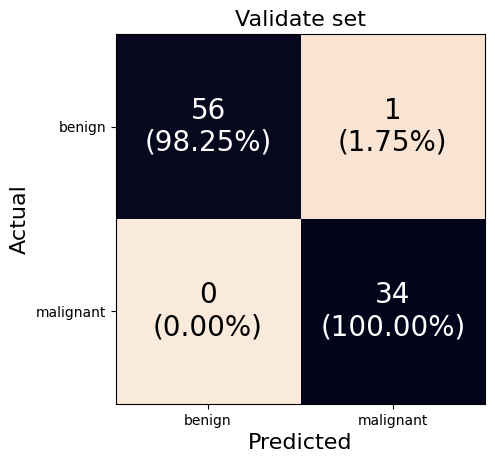

################# test set ##################
Best Threshold=0.499938
FPR: 0.0139
TPR: 0.9762
Confusion Matrix
----------------
[[71  1]
 [ 1 41]] 

----------------
split1
Sensitivity: 97.62%
Specificity: 98.61%
Accuracy: 98.25%
Precision: 97.62%
Sensitivity: 97.62%
Precision: 97.62%
F1: 97.62%


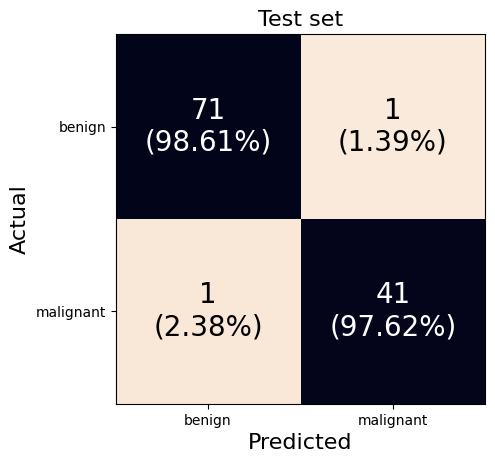

---------------------------------------
AUC validate: 99.90%
AUC test: 98.54%


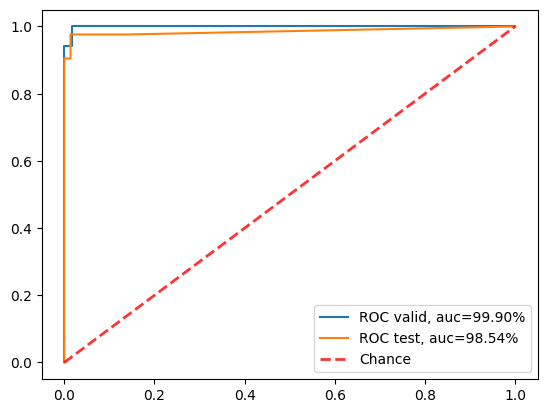

                   Variable      Coef
1                 area_mean  1.168442
7                   area_se  0.745665
3            concavity_mean  0.694726
13          concavity_worst  0.562244
14           symmetry_worst  0.554038
12         smoothness_worst  0.423377
5    fractal_dimension_mean  0.420341
0              texture_mean  0.377628
10              symmetry_se  0.355730
9              concavity_se  0.244096
11     fractal_dimension_se  0.239116
6                texture_se  0.211844
4             symmetry_mean  0.060785
2           smoothness_mean  0.058898
15  fractal_dimension_worst  0.031407
8             smoothness_se  0.006178
################# false predict ##################
        id diagnosis  texture_mean  area_mean  smoothness_mean  \
20  874373         B         17.19      420.3          0.09774   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
20         0.03809         0.1516                 0.06095      0.7655   

    area_se  smoothness

In [139]:
# hello world!
param = 1
param1_split1_cm_val, param1_split1_cm_test, param1_split1_AUC_val, param1_split1_AUC_test = evaluate(param,split)

## split2

In [140]:
split_num = 2
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3/split2/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3/split2/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [141]:
# train_param1(split)

../SGD/models/param1/sgd_model_split2.pkl
############## validate set ################
Best Threshold=0.378314
FPR: 0.0000
TPR: 0.9706
Confusion Matrix
----------------
[[57  0]
 [ 1 33]] 

----------------
split2
Sensitivity: 97.06%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 97.06%
Precision: 100.00%
F1: 98.51%


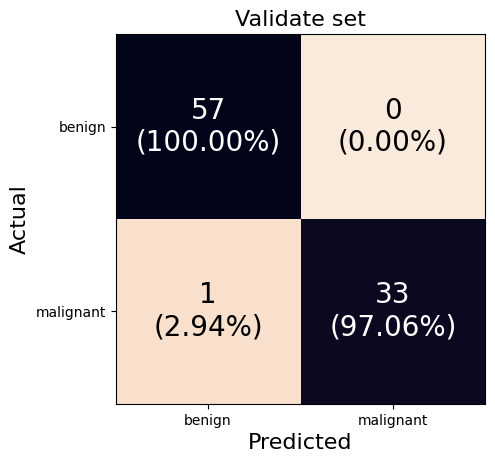

################# test set ##################
Best Threshold=0.574878
FPR: 0.0000
TPR: 0.9524
Confusion Matrix
----------------
[[72  0]
 [ 2 40]] 

----------------
split2
Sensitivity: 95.24%
Specificity: 100.00%
Accuracy: 98.25%
Precision: 100.00%
Sensitivity: 95.24%
Precision: 100.00%
F1: 97.56%


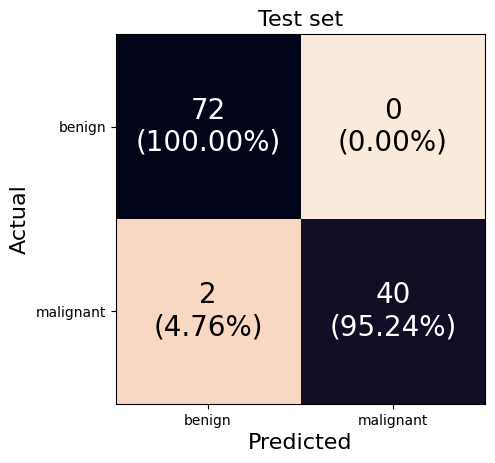

---------------------------------------
AUC validate: 98.27%
AUC test: 98.51%


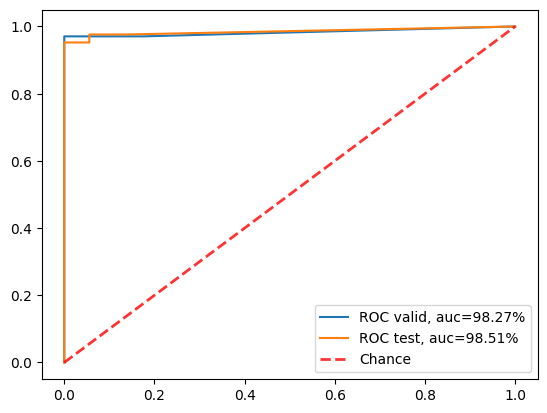

                   Variable      Coef
1                 area_mean  1.272830
3            concavity_mean  0.766608
7                   area_se  0.666232
13          concavity_worst  0.549885
14           symmetry_worst  0.500977
5    fractal_dimension_mean  0.467559
12         smoothness_worst  0.451145
0              texture_mean  0.347270
9              concavity_se  0.343717
10              symmetry_se  0.237205
15  fractal_dimension_worst  0.221037
8             smoothness_se  0.208095
6                texture_se  0.202275
11     fractal_dimension_se  0.182264
4             symmetry_mean  0.064929
2           smoothness_mean  0.000299
################# false predict ##################
        id diagnosis  texture_mean  area_mean  smoothness_mean  \
62  914580         B         17.31      480.1          0.08928   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
62         0.03609         0.1526                 0.06046       0.781   

    area_se  smoothness

In [142]:
param = 1
param1_split2_cm_val, param1_split2_cm_test, param1_split2_AUC_val, param1_split2_AUC_test = evaluate(param,split)

## split3

In [143]:
split_num = 3
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3/split3/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3/split3/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [144]:
# train_param1(split)

../SGD/models/param1/sgd_model_split3.pkl
############## validate set ################
Best Threshold=0.762666
FPR: 0.0000
TPR: 0.9706
Confusion Matrix
----------------
[[57  0]
 [ 1 33]] 

----------------
split3
Sensitivity: 97.06%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 97.06%
Precision: 100.00%
F1: 98.51%


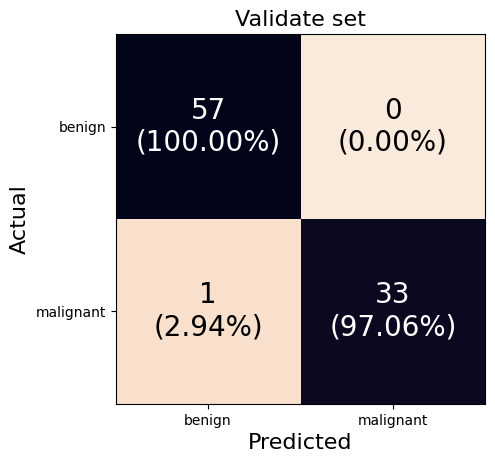

################# test set ##################
Best Threshold=0.486498
FPR: 0.0278
TPR: 0.9762
Confusion Matrix
----------------
[[70  2]
 [ 1 41]] 

----------------
split3
Sensitivity: 97.62%
Specificity: 97.22%
Accuracy: 97.37%
Precision: 95.35%
Sensitivity: 97.62%
Precision: 95.35%
F1: 96.47%


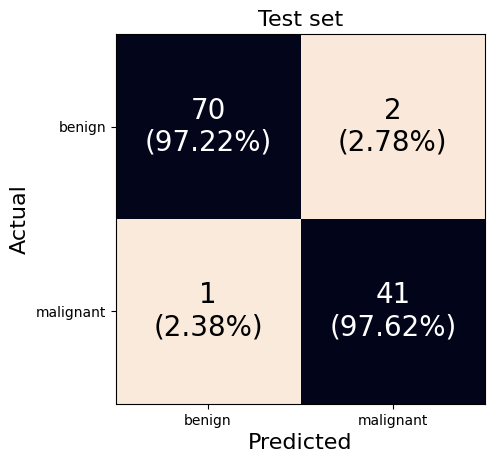

---------------------------------------
AUC validate: 99.85%
AUC test: 98.43%


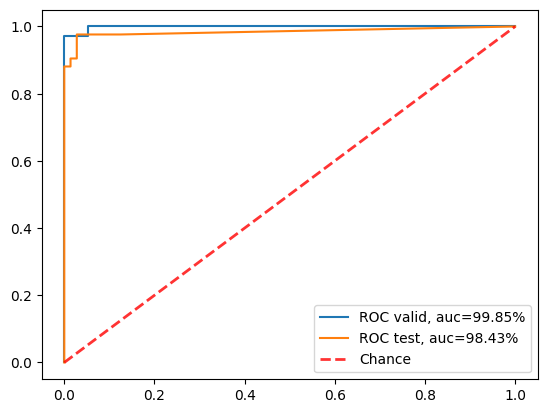

                   Variable      Coef
1                 area_mean  1.363585
7                   area_se  0.821542
3            concavity_mean  0.666173
13          concavity_worst  0.627484
11     fractal_dimension_se  0.467135
14           symmetry_worst  0.394932
0              texture_mean  0.387616
9              concavity_se  0.358881
10              symmetry_se  0.298462
12         smoothness_worst  0.256298
5    fractal_dimension_mean  0.220691
8             smoothness_se  0.193161
6                texture_se  0.185398
15  fractal_dimension_worst  0.140667
4             symmetry_mean  0.077237
2           smoothness_mean  0.010087
################# false predict ##################
         id diagnosis  texture_mean  area_mean  smoothness_mean  \
57  8810528         B         18.94      428.0          0.08871   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
57         0.02669         0.1533                 0.06057      0.8652   

    area_se  smoothne

In [145]:
param = 1
param1_split3_cm_val, param1_split3_cm_test, param1_split3_AUC_val, param1_split3_AUC_test = evaluate(param,split)

## split4

In [146]:
split_num = 4
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3/split4/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3/split4/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [147]:
# train_param1(split)

../SGD/models/param1/sgd_model_split4.pkl
############## validate set ################
Best Threshold=0.428037
FPR: 0.0175
TPR: 1.0000
Confusion Matrix
----------------
[[56  1]
 [ 0 34]] 

----------------
split4
Sensitivity: 100.00%
Specificity: 98.25%
Accuracy: 98.90%
Precision: 97.14%
Sensitivity: 100.00%
Precision: 97.14%
F1: 98.55%


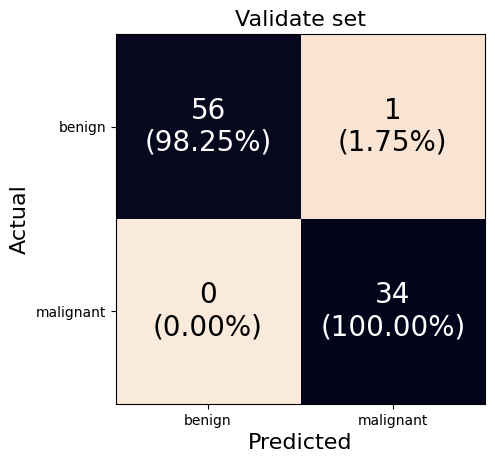

################# test set ##################
Best Threshold=0.546895
FPR: 0.0139
TPR: 0.9524
Confusion Matrix
----------------
[[71  1]
 [ 2 40]] 

----------------
split4
Sensitivity: 95.24%
Specificity: 98.61%
Accuracy: 97.37%
Precision: 97.56%
Sensitivity: 95.24%
Precision: 97.56%
F1: 96.39%


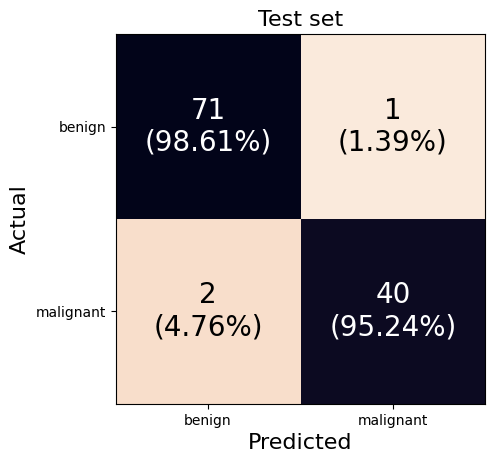

---------------------------------------
AUC validate: 99.95%
AUC test: 98.51%


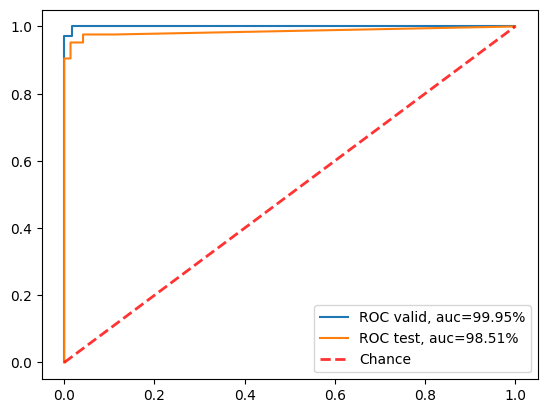

                   Variable      Coef
1                 area_mean  1.120602
3            concavity_mean  0.685115
7                   area_se  0.671758
13          concavity_worst  0.574162
14           symmetry_worst  0.471068
0              texture_mean  0.471059
11     fractal_dimension_se  0.362444
9              concavity_se  0.317522
12         smoothness_worst  0.305295
10              symmetry_se  0.241593
5    fractal_dimension_mean  0.222011
15  fractal_dimension_worst  0.217003
6                texture_se  0.141518
8             smoothness_se  0.110803
2           smoothness_mean  0.030060
4             symmetry_mean  0.011278
################# false predict ##################
        id diagnosis  texture_mean  area_mean  smoothness_mean  \
3  8910721         B         16.82      632.6          0.06429   

   concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  area_se  \
3         0.00725         0.1508                 0.05376      0.7198    10.77   

   smoo

In [148]:
param = 1
param1_split4_cm_val, param1_split4_cm_test, param1_split4_AUC_val, param1_split4_AUC_test = evaluate(param,split)

## split5

In [149]:
split_num = 5
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3/split5/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3/split5/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [150]:
# train_param1(split)

../SGD/models/param1/sgd_model_split5.pkl
############## validate set ################
Best Threshold=0.532519
FPR: 0.0175
TPR: 0.9706
Confusion Matrix
----------------
[[56  1]
 [ 1 33]] 

----------------
split5
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%


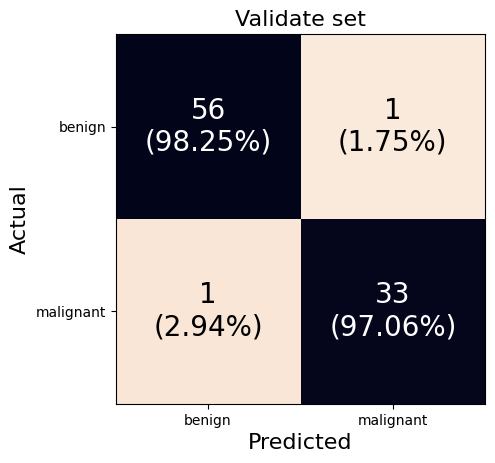

################# test set ##################
Best Threshold=0.590703
FPR: 0.0278
TPR: 0.9524
Confusion Matrix
----------------
[[70  2]
 [ 2 40]] 

----------------
split5
Sensitivity: 95.24%
Specificity: 97.22%
Accuracy: 96.49%
Precision: 95.24%
Sensitivity: 95.24%
Precision: 95.24%
F1: 95.24%


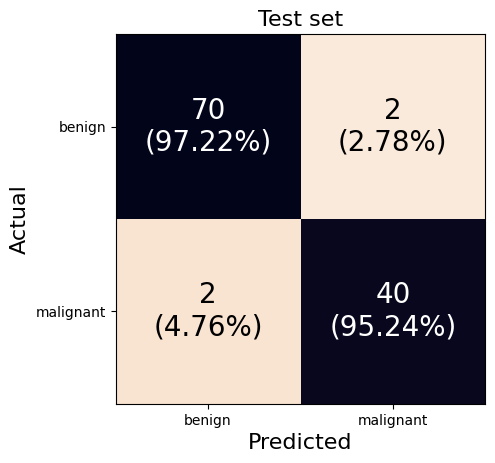

---------------------------------------
AUC validate: 99.54%
AUC test: 98.12%


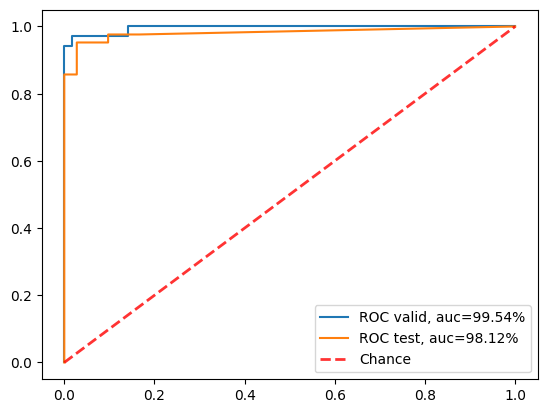

                   Variable      Coef
1                 area_mean  1.213126
7                   area_se  0.883742
3            concavity_mean  0.746705
13          concavity_worst  0.645070
12         smoothness_worst  0.426663
0              texture_mean  0.412511
11     fractal_dimension_se  0.386680
10              symmetry_se  0.380745
9              concavity_se  0.366542
14           symmetry_worst  0.285633
5    fractal_dimension_mean  0.236030
2           smoothness_mean  0.129028
8             smoothness_se  0.082540
6                texture_se  0.067115
4             symmetry_mean  0.061935
15  fractal_dimension_worst  0.059349
################# false predict ##################
         id diagnosis  texture_mean  area_mean  smoothness_mean  \
35  8911230         B         14.16      396.6          0.09379   
79   867739         M         21.91     1075.0          0.09430   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
35        0.001487         0

In [151]:
param = 1
param1_split5_cm_val, param1_split5_cm_test, param1_split5_AUC_val, param1_split5_AUC_test = evaluate(param,split)

# Parameter2

## split1

In [230]:
split_num = 1
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3/split1/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3/split1/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [231]:
# train_param2(split)

../SGD/models/param2/sgd_model_split1.pkl
############## validate set ################
Best Threshold=1.000000
FPR: 0.0175
TPR: 1.0000
Confusion Matrix
----------------
[[56  1]
 [ 0 34]] 

----------------
split1
Sensitivity: 100.00%
Specificity: 98.25%
Accuracy: 98.90%
Precision: 97.14%
Sensitivity: 100.00%
Precision: 97.14%
F1: 98.55%


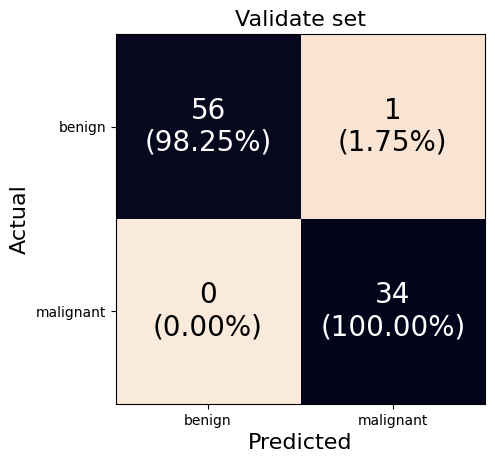

################# test set ##################
Best Threshold=1.000000
FPR: 0.0278
TPR: 0.9762
Confusion Matrix
----------------
[[70  2]
 [ 1 41]] 

----------------
split1
Sensitivity: 97.62%
Specificity: 97.22%
Accuracy: 97.37%
Precision: 95.35%
Sensitivity: 97.62%
Precision: 95.35%
F1: 96.47%


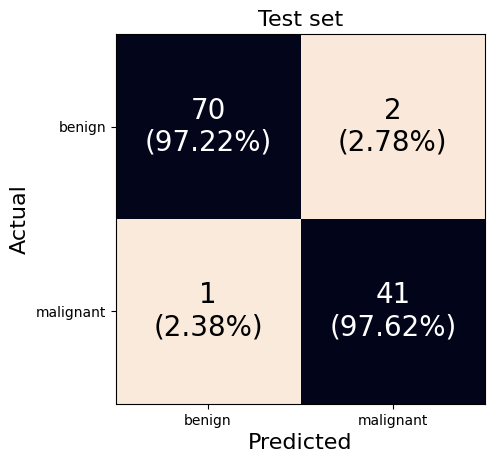

---------------------------------------
AUC validate: 99.12%
AUC test: 97.42%


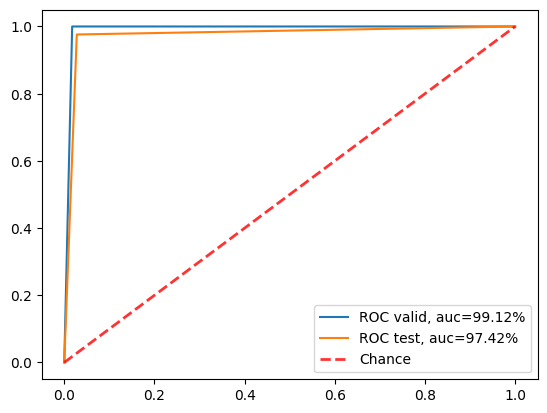

                   Variable         Coef
1                 area_mean  3392.782453
7                   area_se  2285.980878
3            concavity_mean  2166.902221
12         smoothness_worst  1935.466128
13          concavity_worst  1596.018501
0              texture_mean  1404.024810
14           symmetry_worst  1366.705150
9              concavity_se  1222.806569
5    fractal_dimension_mean   982.520898
10              symmetry_se   960.763347
4             symmetry_mean   742.793532
11     fractal_dimension_se   579.990203
2           smoothness_mean   502.847771
15  fractal_dimension_worst   281.333014
6                texture_se   170.090592
8             smoothness_se     5.833132
################# false predict ##################
        id diagnosis  texture_mean  area_mean  smoothness_mean  \
20  874373         B         17.19      420.3          0.09774   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
20         0.03809         0.1516             

In [232]:
param = 2
param2_split1_cm_val, param2_split1_cm_test, param2_split1_AUC_val, param2_split1_AUC_test = evaluate(param,split)

## split2

In [155]:
split_num = 2
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3/split2/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3/split2/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [156]:
# train_param2(split)

../SGD/models/param2/sgd_model_split2.pkl
############## validate set ################
Best Threshold=1.000000
FPR: 0.0175
TPR: 0.9412
Confusion Matrix
----------------
[[56  1]
 [ 2 32]] 

----------------
split2
Sensitivity: 94.12%
Specificity: 98.25%
Accuracy: 96.70%
Precision: 96.97%
Sensitivity: 94.12%
Precision: 96.97%
F1: 95.52%


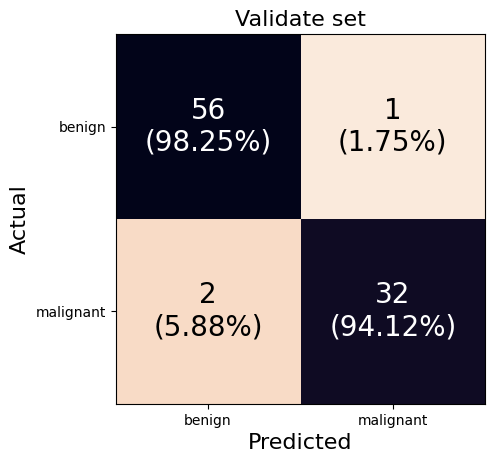

################# test set ##################
Best Threshold=1.000000
FPR: 0.0417
TPR: 0.9524
Confusion Matrix
----------------
[[69  3]
 [ 2 40]] 

----------------
split2
Sensitivity: 95.24%
Specificity: 95.83%
Accuracy: 95.61%
Precision: 93.02%
Sensitivity: 95.24%
Precision: 93.02%
F1: 94.12%


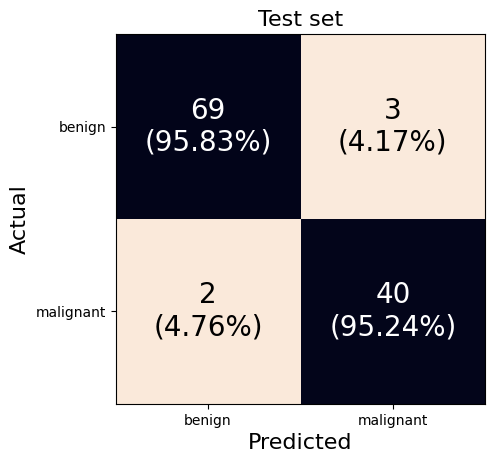

---------------------------------------
AUC validate: 96.18%
AUC test: 95.54%


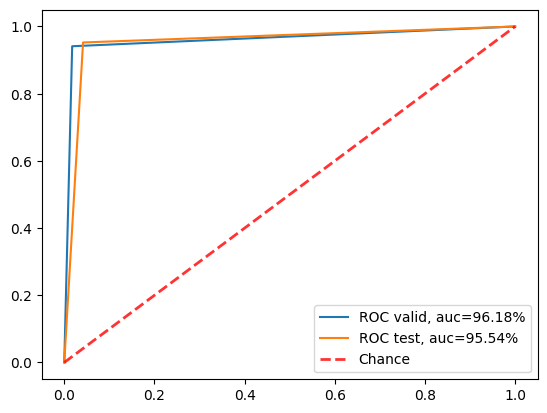

                   Variable         Coef
1                 area_mean  3872.775148
3            concavity_mean  2657.240642
7                   area_se  2109.364375
12         smoothness_worst  1624.937596
14           symmetry_worst  1154.341652
9              concavity_se  1147.527564
13          concavity_worst  1069.615638
0              texture_mean  1056.419547
6                texture_se  1020.158313
10              symmetry_se   986.716708
8             smoothness_se   855.843272
5    fractal_dimension_mean   713.152030
15  fractal_dimension_worst   443.976324
11     fractal_dimension_se   424.534882
4             symmetry_mean   346.311298
2           smoothness_mean    12.093566
################# false predict ##################
        id diagnosis  texture_mean  area_mean  smoothness_mean  \
5    91505         B         16.32      476.3          0.11580   
62  914580         B         17.31      480.1          0.08928   
63  905502         B         17.57      399.8         

In [157]:
param = 2
param2_split2_cm_val, param2_split2_cm_test, param2_split2_AUC_val, param2_split2_AUC_test = evaluate(param,split)

## split3

In [158]:
split_num = 3
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3/split3/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3/split3/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [159]:
# train_param2(split)

../SGD/models/param2/sgd_model_split3.pkl
############## validate set ################
Best Threshold=1.000000
FPR: 0.0175
TPR: 0.9706
Confusion Matrix
----------------
[[56  1]
 [ 1 33]] 

----------------
split3
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%


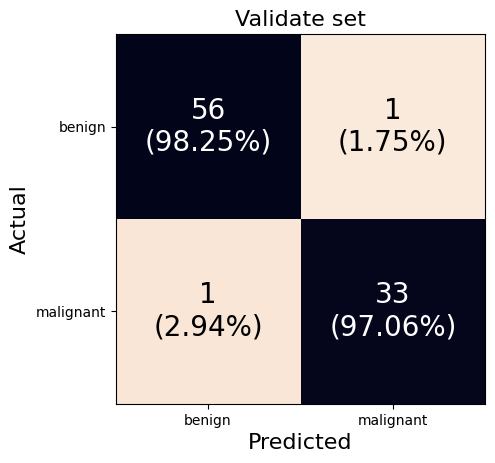

################# test set ##################
Best Threshold=1.000000
FPR: 0.0278
TPR: 0.9762
Confusion Matrix
----------------
[[70  2]
 [ 1 41]] 

----------------
split3
Sensitivity: 97.62%
Specificity: 97.22%
Accuracy: 97.37%
Precision: 95.35%
Sensitivity: 97.62%
Precision: 95.35%
F1: 96.47%


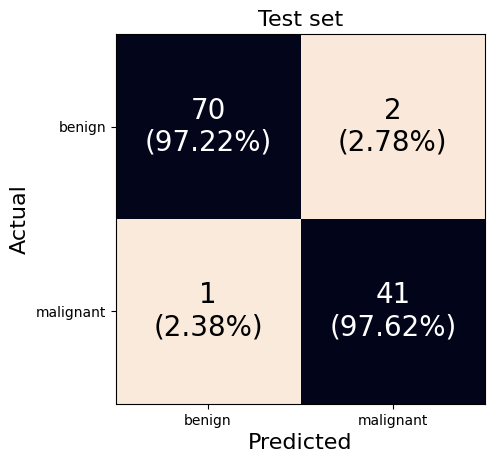

---------------------------------------
AUC validate: 97.65%
AUC test: 97.42%


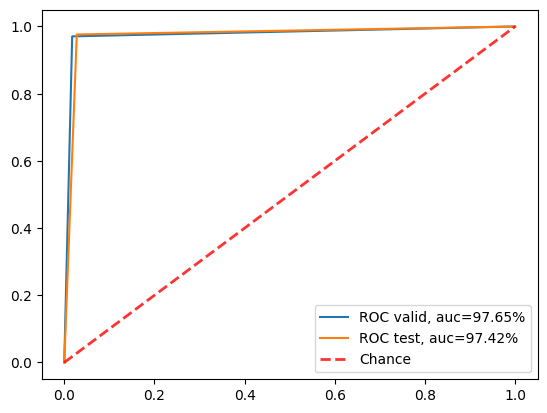

                   Variable         Coef
1                 area_mean  3513.137676
13          concavity_worst  2022.993188
3            concavity_mean  2016.178251
7                   area_se  1896.378426
11     fractal_dimension_se  1431.036880
12         smoothness_worst  1401.316682
9              concavity_se  1291.299927
0              texture_mean   915.010071
14           symmetry_worst   891.901908
10              symmetry_se   733.734546
6                texture_se   709.515181
5    fractal_dimension_mean   649.649477
15  fractal_dimension_worst   576.854210
8             smoothness_se   479.304735
2           smoothness_mean   235.267036
4             symmetry_mean   225.215041
################# false predict ##################
         id diagnosis  texture_mean  area_mean  smoothness_mean  \
14   863270         B         18.54      466.7          0.08477   
57  8810528         B         18.94      428.0          0.08871   

    concavity_mean  symmetry_mean  fractal_dimensi

In [160]:
param = 2
param2_split3_cm_val, param2_split3_cm_test, param2_split3_AUC_val, param2_split3_AUC_test = evaluate(param,split)

## split4

In [161]:
split_num = 4
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3/split4/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3/split4/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [162]:
# train_param2(split)

../SGD/models/param2/sgd_model_split4.pkl
############## validate set ################
Best Threshold=1.000000
FPR: 0.0351
TPR: 1.0000
Confusion Matrix
----------------
[[55  2]
 [ 0 34]] 

----------------
split4
Sensitivity: 100.00%
Specificity: 96.49%
Accuracy: 97.80%
Precision: 94.44%
Sensitivity: 100.00%
Precision: 94.44%
F1: 97.14%


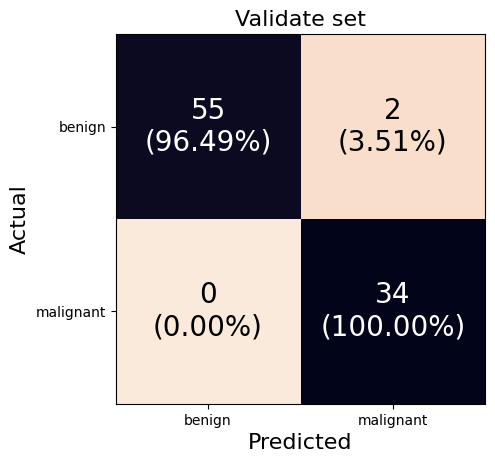

################# test set ##################
Best Threshold=1.000000
FPR: 0.0278
TPR: 0.9762
Confusion Matrix
----------------
[[70  2]
 [ 1 41]] 

----------------
split4
Sensitivity: 97.62%
Specificity: 97.22%
Accuracy: 97.37%
Precision: 95.35%
Sensitivity: 97.62%
Precision: 95.35%
F1: 96.47%


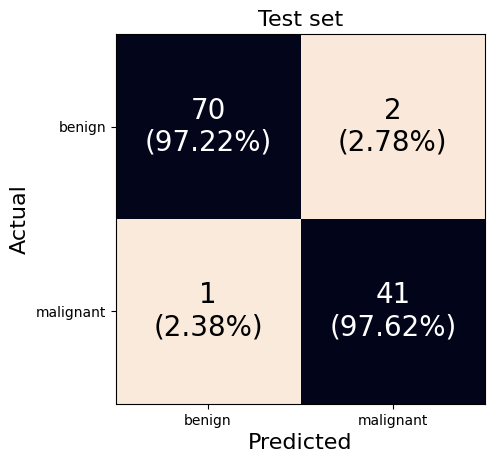

---------------------------------------
AUC validate: 98.25%
AUC test: 97.40%


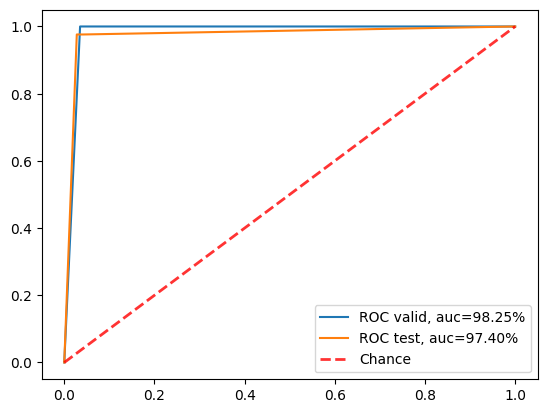

                   Variable         Coef
1                 area_mean  3294.608204
3            concavity_mean  2296.268155
7                   area_se  2040.954001
9              concavity_se  1714.472638
14           symmetry_worst  1174.581222
13          concavity_worst  1169.879696
10              symmetry_se   791.587365
0              texture_mean   782.249107
12         smoothness_worst   729.831343
11     fractal_dimension_se   561.683127
6                texture_se   484.206144
2           smoothness_mean   474.495529
8             smoothness_se   200.205095
4             symmetry_mean   199.068284
5    fractal_dimension_mean    59.026046
15  fractal_dimension_worst    42.577242
################# false predict ##################
         id diagnosis  texture_mean  area_mean  smoothness_mean  \
3   8910721         B         16.82      632.6          0.06429   
25   857373         B         16.34      571.8          0.07685   

    concavity_mean  symmetry_mean  fractal_dimensi

In [163]:
param = 2
param2_split4_cm_val, param2_split4_cm_test, param2_split4_AUC_val, param2_split4_AUC_test = evaluate(param,split)

## split5

In [164]:
split_num = 5
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3/split5/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3/split5/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [165]:
# train_param2(split)

../SGD/models/param2/sgd_model_split5.pkl
############## validate set ################
Best Threshold=1.000000
FPR: 0.0175
TPR: 0.9706
Confusion Matrix
----------------
[[56  1]
 [ 1 33]] 

----------------
split5
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%


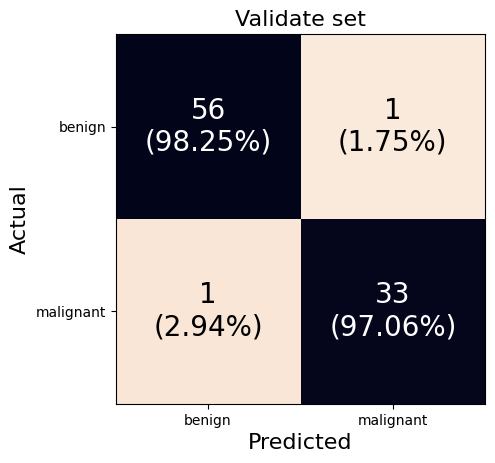

################# test set ##################
Best Threshold=1.000000
FPR: 0.0417
TPR: 0.9286
Confusion Matrix
----------------
[[69  3]
 [ 3 39]] 

----------------
split5
Sensitivity: 92.86%
Specificity: 95.83%
Accuracy: 94.74%
Precision: 92.86%
Sensitivity: 92.86%
Precision: 92.86%
F1: 92.86%


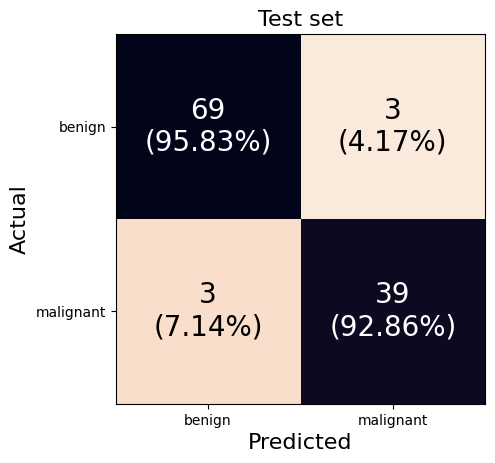

---------------------------------------
AUC validate: 97.65%
AUC test: 94.35%


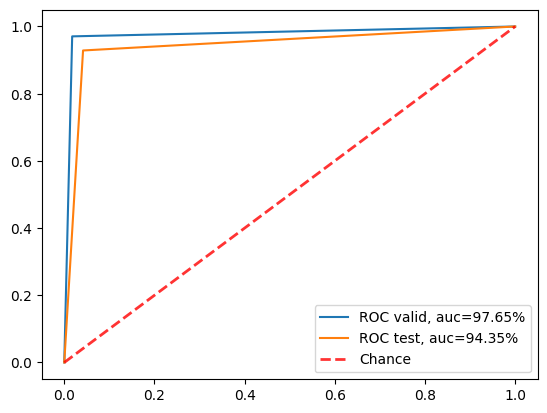

                   Variable         Coef
7                   area_se  3970.365944
1                 area_mean  3735.679335
3            concavity_mean  3527.043493
13          concavity_worst  2739.716437
9              concavity_se  2141.994228
0              texture_mean  1400.000568
2           smoothness_mean  1315.943748
12         smoothness_worst  1208.521036
4             symmetry_mean  1145.431359
11     fractal_dimension_se   610.673749
15  fractal_dimension_worst   596.042352
14           symmetry_worst   429.529736
10              symmetry_se   362.511699
6                texture_se   353.615666
5    fractal_dimension_mean   313.764400
8             smoothness_se   291.589465
################# false predict ##################
         id diagnosis  texture_mean  area_mean  smoothness_mean  \
35  8911230         B         14.16      396.6          0.09379   
79   867739         M         21.91     1075.0          0.09430   

    concavity_mean  symmetry_mean  fractal_dimensi

In [166]:
param = 2
param2_split5_cm_val, param2_split5_cm_test, param2_split5_AUC_val, param2_split5_AUC_test = evaluate(param,split)

# Parameter 3

## split1

In [167]:
split_num = 1
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3/split1/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3/split1/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [168]:
# train_param3(split)

../SGD/models/param3/sgd_model_split1.pkl
############## validate set ################
Best Threshold=1.000000
FPR: 0.0351
TPR: 0.9706
Confusion Matrix
----------------
[[55  2]
 [ 1 33]] 

----------------
split1
Sensitivity: 97.06%
Specificity: 96.49%
Accuracy: 96.70%
Precision: 94.29%
Sensitivity: 97.06%
Precision: 94.29%
F1: 95.65%


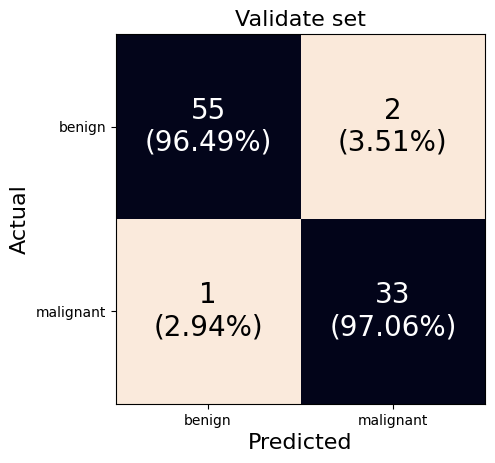

################# test set ##################
Best Threshold=1.000000
FPR: 0.0694
TPR: 0.9762
Confusion Matrix
----------------
[[67  5]
 [ 1 41]] 

----------------
split1
Sensitivity: 97.62%
Specificity: 93.06%
Accuracy: 94.74%
Precision: 89.13%
Sensitivity: 97.62%
Precision: 89.13%
F1: 93.18%


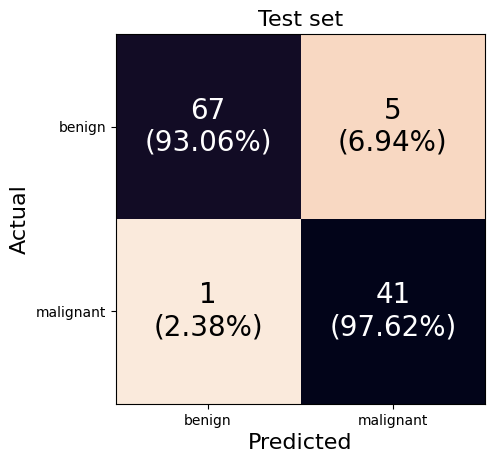

---------------------------------------
AUC validate: 96.78%
AUC test: 95.34%


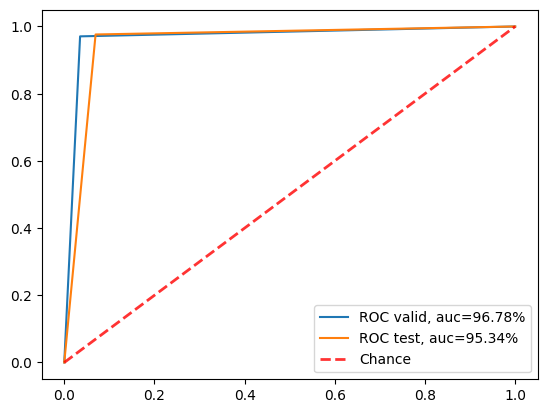

                   Variable         Coef
1                 area_mean  3817.800014
7                   area_se  2501.148287
14           symmetry_worst  2013.596720
12         smoothness_worst  1830.849758
3            concavity_mean  1784.687502
0              texture_mean  1587.221193
6                texture_se  1271.926173
9              concavity_se  1252.377967
13          concavity_worst  1146.619225
5    fractal_dimension_mean   991.008608
11     fractal_dimension_se   779.652104
10              symmetry_se   724.377610
8             smoothness_se   582.914913
4             symmetry_mean   342.123565
2           smoothness_mean   242.904435
15  fractal_dimension_worst   110.353494
################# false predict ##################
         id diagnosis  texture_mean  area_mean  smoothness_mean  \
20   874373         B         17.19      420.3          0.09774   
21   904357         B         17.26      431.9          0.09087   
88  8812877         M         20.25      761.3     

In [169]:
param = 3
param3_split1_cm_val, param3_split1_cm_test, param3_split1_AUC_val, param3_split1_AUC_test = evaluate(param,split)

## split2

In [170]:
split_num = 2
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3/split2/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3/split2/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [171]:
# train_param3(split)

../SGD/models/param3/sgd_model_split2.pkl
############## validate set ################
Best Threshold=1.000000
FPR: 0.0000
TPR: 0.9706
Confusion Matrix
----------------
[[57  0]
 [ 1 33]] 

----------------
split2
Sensitivity: 97.06%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 97.06%
Precision: 100.00%
F1: 98.51%


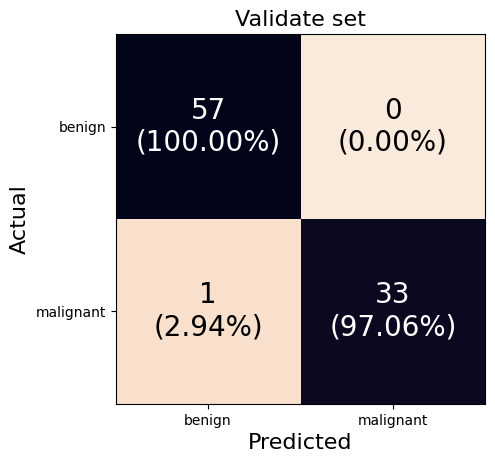

################# test set ##################
Best Threshold=1.000000
FPR: 0.0417
TPR: 0.9524
Confusion Matrix
----------------
[[69  3]
 [ 2 40]] 

----------------
split2
Sensitivity: 95.24%
Specificity: 95.83%
Accuracy: 95.61%
Precision: 93.02%
Sensitivity: 95.24%
Precision: 93.02%
F1: 94.12%


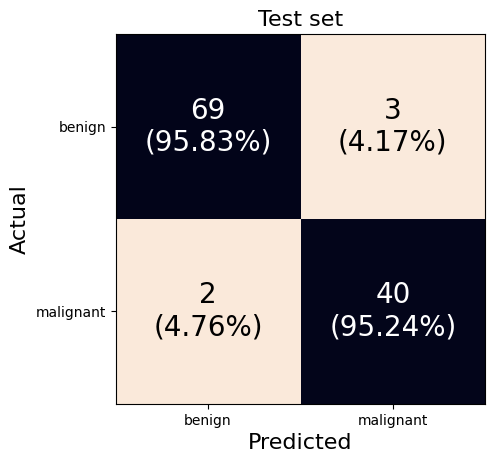

---------------------------------------
AUC validate: 98.53%
AUC test: 95.54%


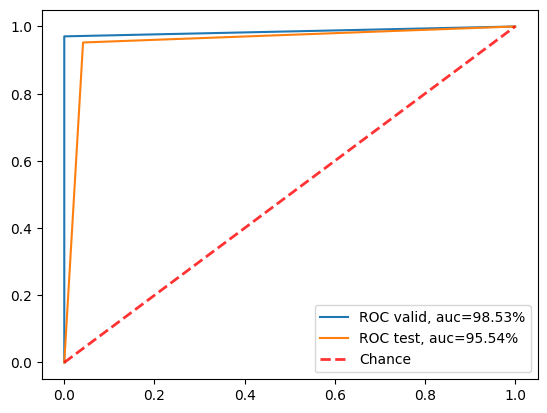

                   Variable         Coef
1                 area_mean  4416.359885
7                   area_se  2464.936898
3            concavity_mean  2011.757026
12         smoothness_worst  1705.211070
9              concavity_se  1314.527570
5    fractal_dimension_mean  1207.564097
14           symmetry_worst   849.263201
10              symmetry_se   774.510316
13          concavity_worst   704.151063
15  fractal_dimension_worst   602.484488
0              texture_mean   563.497158
6                texture_se   523.594286
8             smoothness_se   414.694956
2           smoothness_mean   273.141931
11     fractal_dimension_se   192.056982
4             symmetry_mean    98.063805
################# false predict ##################
        id diagnosis  texture_mean  area_mean  smoothness_mean  \
62  914580         B         17.31      480.1          0.08928   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
62         0.03609         0.1526             

In [172]:
param = 3
param3_split2_cm_val, param3_split2_cm_test, param3_split2_AUC_val, param3_split2_AUC_test = evaluate(param,split)

## split3

In [173]:
split_num = 3
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3/split3/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3/split3/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [174]:
# train_param3(split)

../SGD/models/param3/sgd_model_split3.pkl
############## validate set ################
Best Threshold=1.000000
FPR: 0.0175
TPR: 0.9706
Confusion Matrix
----------------
[[56  1]
 [ 1 33]] 

----------------
split3
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%


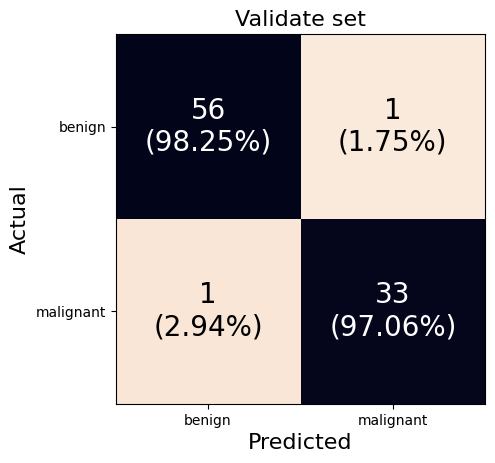

################# test set ##################
Best Threshold=1.000000
FPR: 0.0278
TPR: 0.9762
Confusion Matrix
----------------
[[70  2]
 [ 1 41]] 

----------------
split3
Sensitivity: 97.62%
Specificity: 97.22%
Accuracy: 97.37%
Precision: 95.35%
Sensitivity: 97.62%
Precision: 95.35%
F1: 96.47%


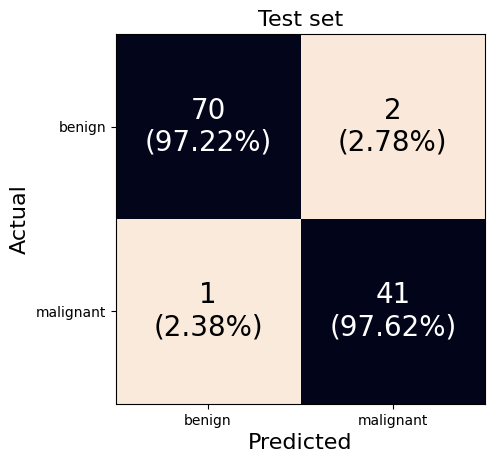

---------------------------------------
AUC validate: 97.65%
AUC test: 97.42%


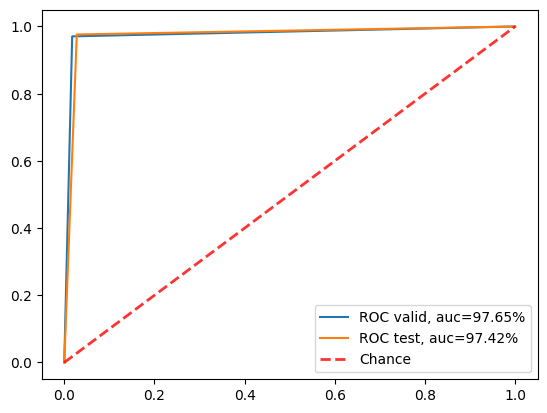

                   Variable         Coef
1                 area_mean  4036.897175
7                   area_se  2380.612369
3            concavity_mean  2253.384357
11     fractal_dimension_se  1533.047775
9              concavity_se  1525.784113
12         smoothness_worst  1485.063590
14           symmetry_worst  1362.960985
13          concavity_worst  1315.948686
0              texture_mean  1071.966549
2           smoothness_mean   763.299228
15  fractal_dimension_worst   630.218623
6                texture_se   493.343586
5    fractal_dimension_mean   384.288853
4             symmetry_mean   279.985797
8             smoothness_se   169.363956
10              symmetry_se    96.321399
################# false predict ##################
         id diagnosis  texture_mean  area_mean  smoothness_mean  \
14   863270         B         18.54      466.7          0.08477   
57  8810528         B         18.94      428.0          0.08871   

    concavity_mean  symmetry_mean  fractal_dimensi

In [175]:
param = 3
param3_split3_cm_val, param3_split3_cm_test, param3_split3_AUC_val, param3_split3_AUC_test = evaluate(param,split)

## split4

In [176]:
split_num = 4
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3/split4/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3/split4/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [177]:
# train_param3(split)

../SGD/models/param3/sgd_model_split4.pkl
############## validate set ################
Best Threshold=1.000000
FPR: 0.0351
TPR: 1.0000
Confusion Matrix
----------------
[[55  2]
 [ 0 34]] 

----------------
split4
Sensitivity: 100.00%
Specificity: 96.49%
Accuracy: 97.80%
Precision: 94.44%
Sensitivity: 100.00%
Precision: 94.44%
F1: 97.14%


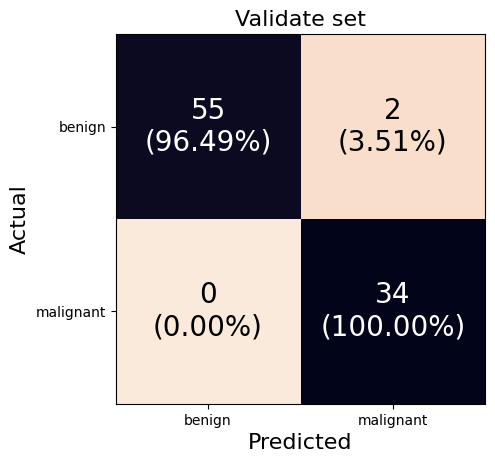

################# test set ##################
Best Threshold=1.000000
FPR: 0.0278
TPR: 0.9524
Confusion Matrix
----------------
[[70  2]
 [ 2 40]] 

----------------
split4
Sensitivity: 95.24%
Specificity: 97.22%
Accuracy: 96.49%
Precision: 95.24%
Sensitivity: 95.24%
Precision: 95.24%
F1: 95.24%


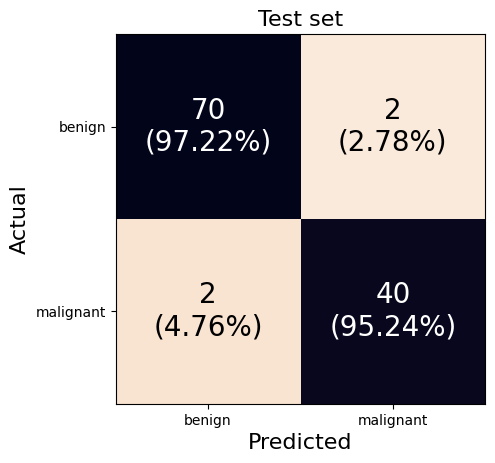

---------------------------------------
AUC validate: 98.25%
AUC test: 96.23%


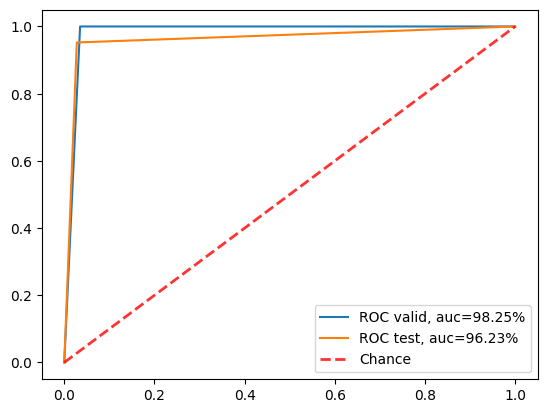

                   Variable         Coef
1                 area_mean  3102.956848
3            concavity_mean  2587.513761
7                   area_se  2182.294061
13          concavity_worst  1456.243414
14           symmetry_worst  1454.449614
9              concavity_se  1246.668176
11     fractal_dimension_se  1237.353826
10              symmetry_se  1045.764075
15  fractal_dimension_worst  1002.503480
12         smoothness_worst   914.267761
4             symmetry_mean   614.079010
6                texture_se   524.065298
5    fractal_dimension_mean   431.851037
0              texture_mean   268.808755
8             smoothness_se   129.090831
2           smoothness_mean    38.071330
################# false predict ##################
         id diagnosis  texture_mean  area_mean  smoothness_mean  \
3   8910721         B         16.82      632.6          0.06429   
29    87127         B          9.71      357.6          0.09594   

    concavity_mean  symmetry_mean  fractal_dimensi

In [178]:
param = 3
param3_split4_cm_val, param3_split4_cm_test, param3_split4_AUC_val, param3_split4_AUC_test = evaluate(param,split)

## split5

In [179]:
split_num = 5
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3/split5/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3/split5/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [180]:
# train_param3(split)

../SGD/models/param3/sgd_model_split5.pkl
############## validate set ################
Best Threshold=1.000000
FPR: 0.0175
TPR: 0.9706
Confusion Matrix
----------------
[[56  1]
 [ 1 33]] 

----------------
split5
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%


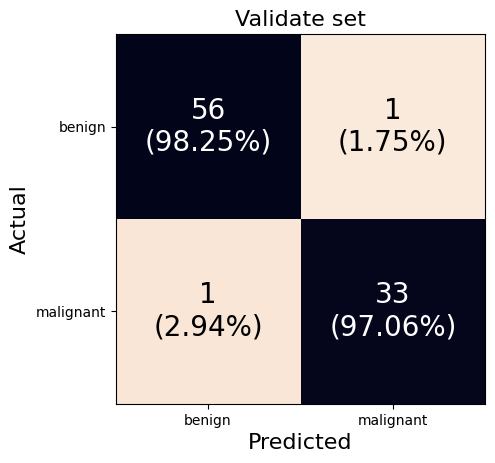

################# test set ##################
Best Threshold=1.000000
FPR: 0.0139
TPR: 0.9286
Confusion Matrix
----------------
[[71  1]
 [ 3 39]] 

----------------
split5
Sensitivity: 92.86%
Specificity: 98.61%
Accuracy: 96.49%
Precision: 97.50%
Sensitivity: 92.86%
Precision: 97.50%
F1: 95.12%


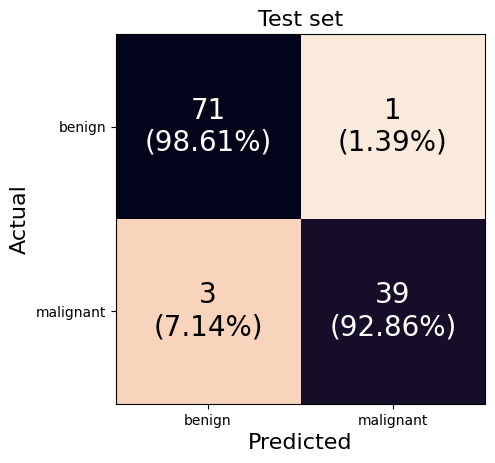

---------------------------------------
AUC validate: 97.65%
AUC test: 95.73%


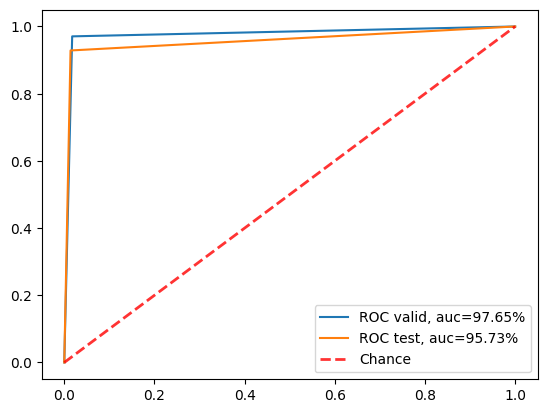

                   Variable         Coef
1                 area_mean  3590.264126
7                   area_se  3219.330356
3            concavity_mean  2583.633750
13          concavity_worst  2453.100250
9              concavity_se  1638.458573
12         smoothness_worst  1506.286930
0              texture_mean  1116.781733
14           symmetry_worst   994.081202
11     fractal_dimension_se   932.827104
4             symmetry_mean   608.365804
2           smoothness_mean   587.433106
10              symmetry_se   575.695587
5    fractal_dimension_mean   498.821776
8             smoothness_se   460.005786
15  fractal_dimension_worst   349.213087
6                texture_se    33.428176
################# false predict ##################
         id diagnosis  texture_mean  area_mean  smoothness_mean  \
35  8911230         B         14.16      396.6          0.09379   
79   867739         M         21.91     1075.0          0.09430   

    concavity_mean  symmetry_mean  fractal_dimensi

In [181]:
param = 3
param3_split5_cm_val, param3_split5_cm_test, param3_split5_AUC_val, param3_split5_AUC_test = evaluate(param,split)

# Parameter 4

## split1

In [182]:
split_num = 1
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3/split1/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3/split1/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [183]:
# train_param4(split)

../SGD/models/param4/sgd_model_split1.pkl
############## validate set ################
Best Threshold=0.626909
FPR: 0.0000
TPR: 0.9706
Confusion Matrix
----------------
[[57  0]
 [ 1 33]] 

----------------
split1
Sensitivity: 97.06%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 97.06%
Precision: 100.00%
F1: 98.51%


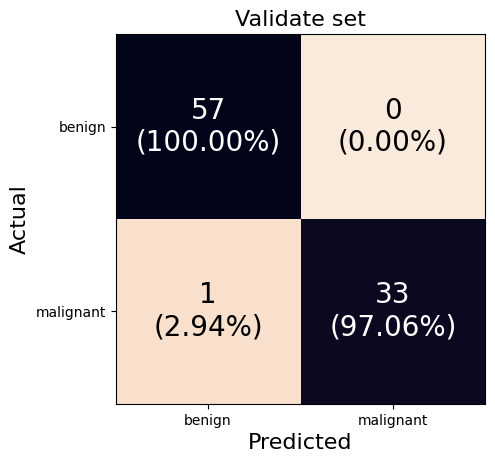

################# test set ##################
Best Threshold=0.496966
FPR: 0.0000
TPR: 0.9524
Confusion Matrix
----------------
[[72  0]
 [ 2 40]] 

----------------
split1
Sensitivity: 95.24%
Specificity: 100.00%
Accuracy: 98.25%
Precision: 100.00%
Sensitivity: 95.24%
Precision: 100.00%
F1: 97.56%


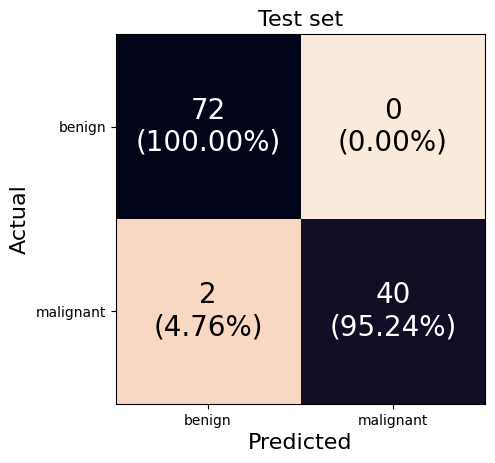

---------------------------------------
AUC validate: 99.90%
AUC test: 98.05%


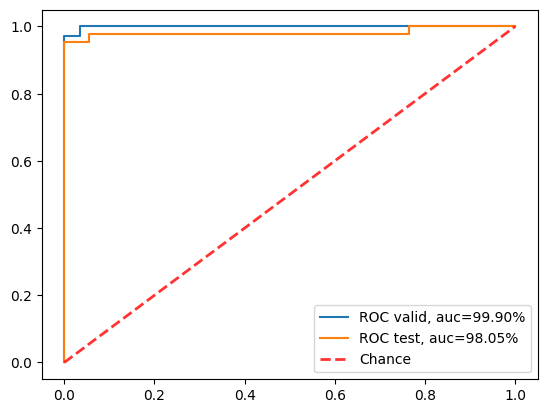

                   Variable      Coef
1                 area_mean  3.762159
12         smoothness_worst  1.277764
3            concavity_mean  1.198247
0              texture_mean  0.972278
14           symmetry_worst  0.359231
11     fractal_dimension_se  0.292696
13          concavity_worst  0.175174
10              symmetry_se  0.031311
2           smoothness_mean  0.000000
4             symmetry_mean  0.000000
5    fractal_dimension_mean  0.000000
6                texture_se  0.000000
7                   area_se  0.000000
8             smoothness_se  0.000000
9              concavity_se  0.000000
15  fractal_dimension_worst  0.000000
################# false predict ##################
         id diagnosis  texture_mean  area_mean  smoothness_mean  \
65  9013594         B         15.15      580.6          0.08268   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
65         0.04249         0.1792                 0.05897      0.5417   

    area_se  smoothne

In [184]:
param = 4
param4_split1_cm_val, param4_split1_cm_test, param4_split1_AUC_val, param4_split1_AUC_test = evaluate(param,split)

## split2

In [185]:
split_num = 2
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3/split2/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3/split2/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [186]:
# train_param4(split)

../SGD/models/param4/sgd_model_split2.pkl
############## validate set ################
Best Threshold=0.397465
FPR: 0.0000
TPR: 0.9706
Confusion Matrix
----------------
[[57  0]
 [ 1 33]] 

----------------
split2
Sensitivity: 97.06%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 97.06%
Precision: 100.00%
F1: 98.51%


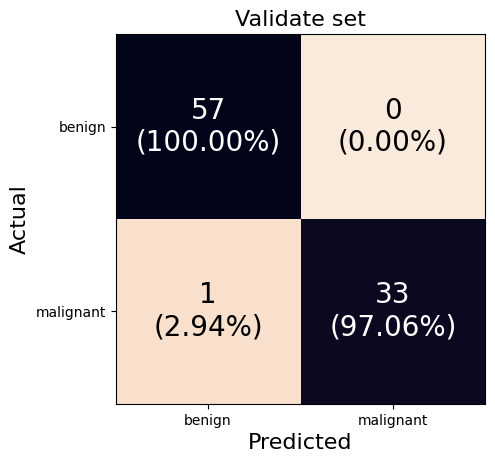

################# test set ##################
Best Threshold=0.570333
FPR: 0.0000
TPR: 0.9286
Confusion Matrix
----------------
[[72  0]
 [ 3 39]] 

----------------
split2
Sensitivity: 92.86%
Specificity: 100.00%
Accuracy: 97.37%
Precision: 100.00%
Sensitivity: 92.86%
Precision: 100.00%
F1: 96.30%


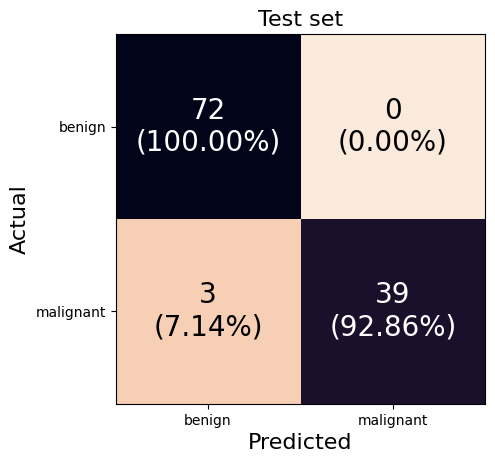

---------------------------------------
AUC validate: 99.23%
AUC test: 98.21%


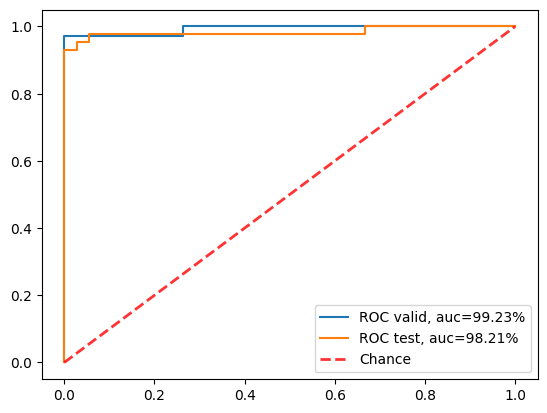

                   Variable      Coef
1                 area_mean  4.638817
12         smoothness_worst  1.741989
0              texture_mean  1.211557
13          concavity_worst  0.841549
3            concavity_mean  0.677563
7                   area_se  0.617355
9              concavity_se  0.261603
14           symmetry_worst  0.161496
2           smoothness_mean  0.000000
4             symmetry_mean  0.000000
5    fractal_dimension_mean  0.000000
6                texture_se  0.000000
8             smoothness_se  0.000000
10              symmetry_se  0.000000
11     fractal_dimension_se  0.000000
15  fractal_dimension_worst  0.000000
################# false predict ##################
        id diagnosis  texture_mean  area_mean  smoothness_mean  \
62  914580         B         17.31      480.1          0.08928   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
62         0.03609         0.1526                 0.06046       0.781   

    area_se  smoothness

In [187]:
param = 4
param4_split2_cm_val, param4_split2_cm_test, param4_split2_AUC_val, param4_split2_AUC_test = evaluate(param,split)

## split3

In [188]:
split_num = 3
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3/split3/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3/split3/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [189]:
# train_param4(split)

../SGD/models/param4/sgd_model_split3.pkl
############## validate set ################
Best Threshold=0.336172
FPR: 0.0526
TPR: 0.9706
Confusion Matrix
----------------
[[54  3]
 [ 1 33]] 

----------------
split3
Sensitivity: 97.06%
Specificity: 94.74%
Accuracy: 95.60%
Precision: 91.67%
Sensitivity: 97.06%
Precision: 91.67%
F1: 94.29%


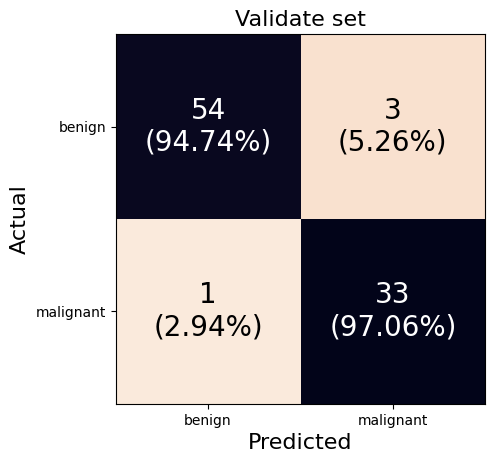

################# test set ##################
Best Threshold=0.382008
FPR: 0.0278
TPR: 0.9524
Confusion Matrix
----------------
[[70  2]
 [ 2 40]] 

----------------
split3
Sensitivity: 95.24%
Specificity: 97.22%
Accuracy: 96.49%
Precision: 95.24%
Sensitivity: 95.24%
Precision: 95.24%
F1: 95.24%


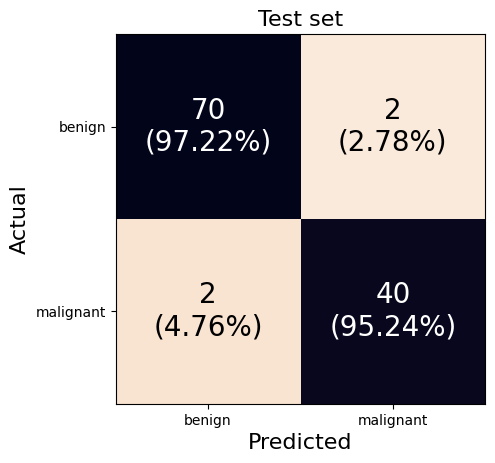

---------------------------------------
AUC validate: 99.12%
AUC test: 97.95%


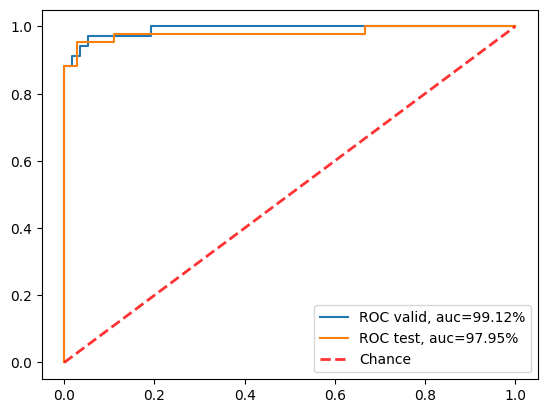

                   Variable      Coef
1                 area_mean  6.284682
0              texture_mean  1.371294
13          concavity_worst  1.118529
3            concavity_mean  1.071353
15  fractal_dimension_worst  1.068605
12         smoothness_worst  0.900997
7                   area_se  0.646644
5    fractal_dimension_mean  0.445828
9              concavity_se  0.276794
2           smoothness_mean  0.000000
4             symmetry_mean  0.000000
6                texture_se  0.000000
8             smoothness_se  0.000000
10              symmetry_se  0.000000
11     fractal_dimension_se  0.000000
14           symmetry_worst  0.000000
################# false predict ##################
          id diagnosis  texture_mean  area_mean  smoothness_mean  \
0     904969         B         14.95      469.1          0.08682   
13    899187         B         17.07      421.0          0.07561   
32  88350402         B         15.60      575.3          0.09423   
57   8810528         B         

In [190]:
param = 4
param4_split3_cm_val, param4_split3_cm_test, param4_split3_AUC_val, param4_split3_AUC_test = evaluate(param,split)

## split4

In [191]:
split_num = 4
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3/split4/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3/split4/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [192]:
# train_param4(split)

../SGD/models/param4/sgd_model_split4.pkl
############## validate set ################
Best Threshold=0.374013
FPR: 0.0175
TPR: 1.0000
Confusion Matrix
----------------
[[56  1]
 [ 0 34]] 

----------------
split4
Sensitivity: 100.00%
Specificity: 98.25%
Accuracy: 98.90%
Precision: 97.14%
Sensitivity: 100.00%
Precision: 97.14%
F1: 98.55%


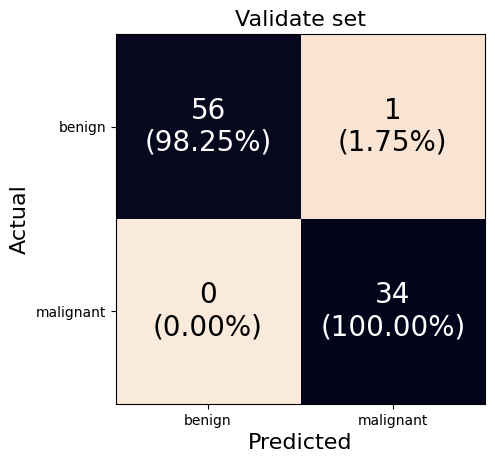

################# test set ##################
Best Threshold=0.534372
FPR: 0.0000
TPR: 0.9524
Confusion Matrix
----------------
[[72  0]
 [ 2 40]] 

----------------
split4
Sensitivity: 95.24%
Specificity: 100.00%
Accuracy: 98.25%
Precision: 100.00%
Sensitivity: 95.24%
Precision: 100.00%
F1: 97.56%


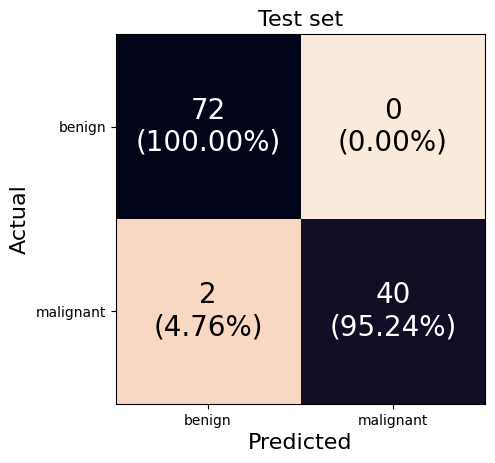

---------------------------------------
AUC validate: 99.85%
AUC test: 98.28%


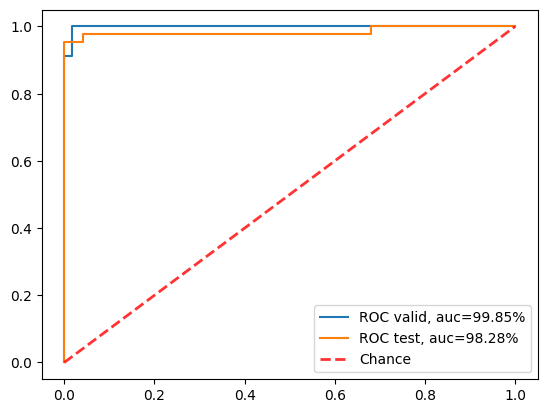

                   Variable      Coef
1                 area_mean  3.400896
12         smoothness_worst  1.109593
0              texture_mean  1.027170
13          concavity_worst  0.731965
7                   area_se  0.728331
14           symmetry_worst  0.610673
3            concavity_mean  0.498708
9              concavity_se  0.342137
10              symmetry_se  0.138032
2           smoothness_mean  0.000000
4             symmetry_mean  0.000000
5    fractal_dimension_mean  0.000000
6                texture_se  0.000000
8             smoothness_se  0.000000
11     fractal_dimension_se  0.000000
15  fractal_dimension_worst  0.000000
################# false predict ##################
        id diagnosis  texture_mean  area_mean  smoothness_mean  \
3  8910721         B         16.82      632.6          0.06429   

   concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  area_se  \
3         0.00725         0.1508                 0.05376      0.7198    10.77   

   smoo

In [193]:
param = 4
param4_split4_cm_val, param4_split4_cm_test, param4_split4_AUC_val, param4_split4_AUC_test = evaluate(param,split)

## split5

In [194]:
split_num = 5
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3/split5/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3/split5/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [195]:
# train_param4(split)

../SGD/models/param4/sgd_model_split5.pkl
############## validate set ################
Best Threshold=0.918494
FPR: 0.0000
TPR: 0.9412
Confusion Matrix
----------------
[[57  0]
 [ 2 32]] 

----------------
split5
Sensitivity: 94.12%
Specificity: 100.00%
Accuracy: 97.80%
Precision: 100.00%
Sensitivity: 94.12%
Precision: 100.00%
F1: 96.97%


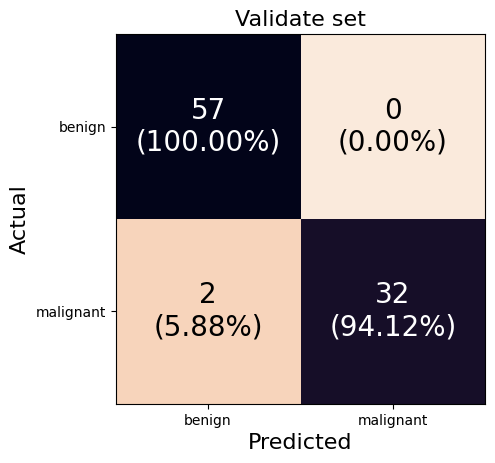

################# test set ##################
Best Threshold=0.273592
FPR: 0.0417
TPR: 0.9762
Confusion Matrix
----------------
[[69  3]
 [ 1 41]] 

----------------
split5
Sensitivity: 97.62%
Specificity: 95.83%
Accuracy: 96.49%
Precision: 93.18%
Sensitivity: 97.62%
Precision: 93.18%
F1: 95.35%


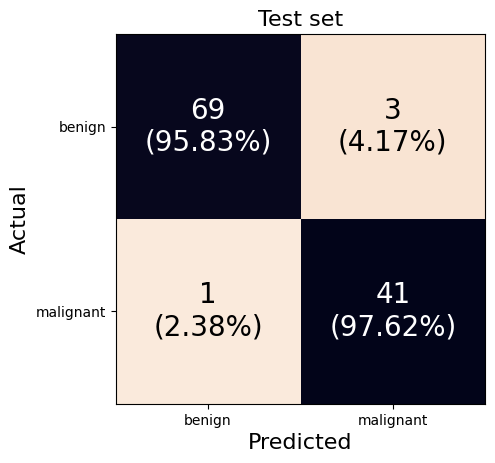

---------------------------------------
AUC validate: 99.33%
AUC test: 98.54%


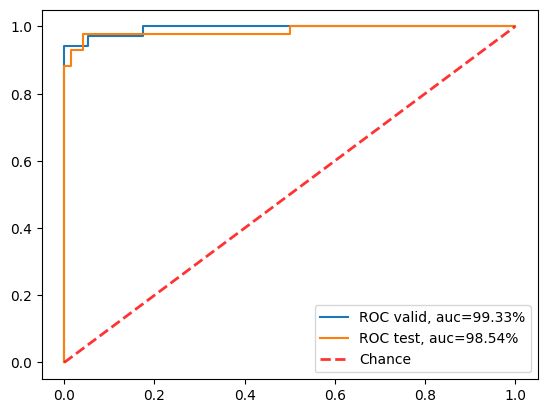

                   Variable      Coef
1                 area_mean  5.579457
3            concavity_mean  2.120377
7                   area_se  1.986208
12         smoothness_worst  1.670579
0              texture_mean  1.334383
9              concavity_se  0.733467
13          concavity_worst  0.704522
14           symmetry_worst  0.098677
11     fractal_dimension_se  0.087251
2           smoothness_mean  0.000000
4             symmetry_mean  0.000000
5    fractal_dimension_mean  0.000000
6                texture_se  0.000000
8             smoothness_se  0.000000
10              symmetry_se  0.000000
15  fractal_dimension_worst  0.000000
################# false predict ##################
        id diagnosis  texture_mean  area_mean  smoothness_mean  \
62  914580         B         17.31      480.1          0.08928   
79  867739         M         21.91     1075.0          0.09430   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
62         0.03609         0.15

In [196]:
param = 4
param4_split5_cm_val, param4_split5_cm_test, param4_split5_AUC_val, param4_split5_AUC_test = evaluate(param,split)

# Parameter 5

## split1

In [197]:
split_num = 1
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3/split1/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3/split1/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [198]:
# train_param5(split)

../SGD/models/param5/sgd_model_split1.pkl
############## validate set ################
Best Threshold=0.436042
FPR: 0.0175
TPR: 1.0000
Confusion Matrix
----------------
[[56  1]
 [ 0 34]] 

----------------
split1
Sensitivity: 100.00%
Specificity: 98.25%
Accuracy: 98.90%
Precision: 97.14%
Sensitivity: 100.00%
Precision: 97.14%
F1: 98.55%


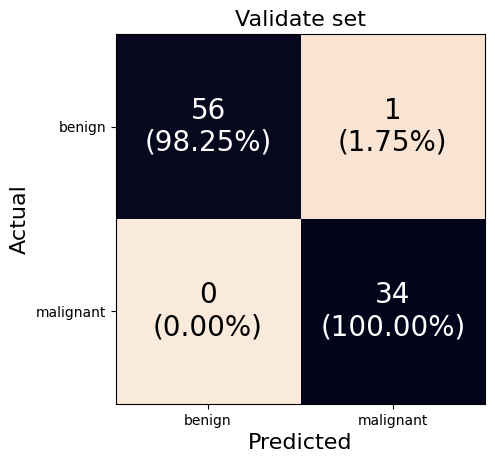

################# test set ##################
Best Threshold=0.514098
FPR: 0.0278
TPR: 0.9762
Confusion Matrix
----------------
[[70  2]
 [ 1 41]] 

----------------
split1
Sensitivity: 97.62%
Specificity: 97.22%
Accuracy: 97.37%
Precision: 95.35%
Sensitivity: 97.62%
Precision: 95.35%
F1: 96.47%


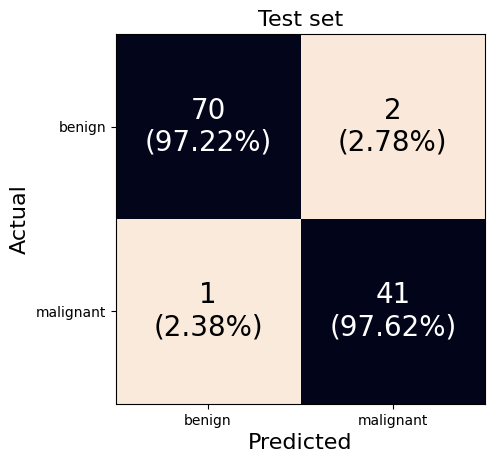

---------------------------------------
AUC validate: 99.85%
AUC test: 98.38%


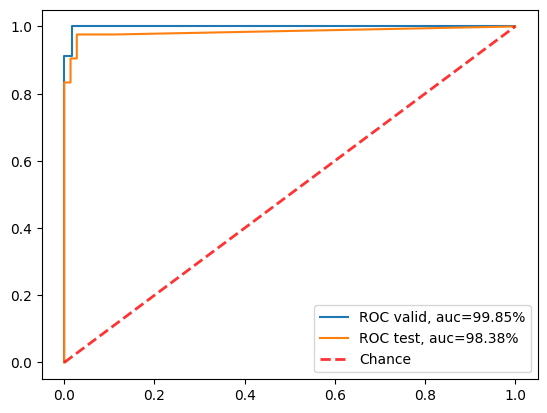

                   Variable      Coef
1                 area_mean  1.675663
7                   area_se  1.053166
3            concavity_mean  0.956633
14           symmetry_worst  0.948493
10              symmetry_se  0.739655
13          concavity_worst  0.698077
12         smoothness_worst  0.597575
5    fractal_dimension_mean  0.546349
0              texture_mean  0.543919
11     fractal_dimension_se  0.431255
6                texture_se  0.369452
9              concavity_se  0.282886
15  fractal_dimension_worst  0.069987
8             smoothness_se  0.048195
2           smoothness_mean  0.036318
4             symmetry_mean  0.024721
################# false predict ##################
        id diagnosis  texture_mean  area_mean  smoothness_mean  \
20  874373         B         17.19      420.3          0.09774   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
20         0.03809         0.1516                 0.06095      0.7655   

    area_se  smoothness

In [199]:
param = 5
param5_split1_cm_val, param5_split1_cm_test, param5_split1_AUC_val, param5_split1_AUC_test = evaluate(param,split)

## split2

In [200]:
split_num = 2
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3/split2/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3/split2/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [201]:
# train_param5(split)

../SGD/models/param5/sgd_model_split2.pkl
############## validate set ################
Best Threshold=0.475486
FPR: 0.0000
TPR: 0.9706
Confusion Matrix
----------------
[[57  0]
 [ 1 33]] 

----------------
split2
Sensitivity: 97.06%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 97.06%
Precision: 100.00%
F1: 98.51%


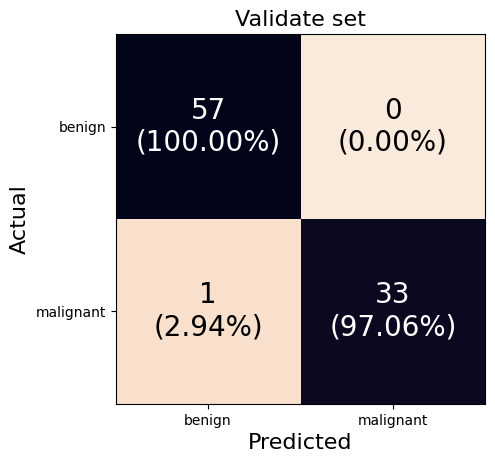

################# test set ##################
Best Threshold=0.213483
FPR: 0.0694
TPR: 0.9762
Confusion Matrix
----------------
[[67  5]
 [ 1 41]] 

----------------
split2
Sensitivity: 97.62%
Specificity: 93.06%
Accuracy: 94.74%
Precision: 89.13%
Sensitivity: 97.62%
Precision: 89.13%
F1: 93.18%


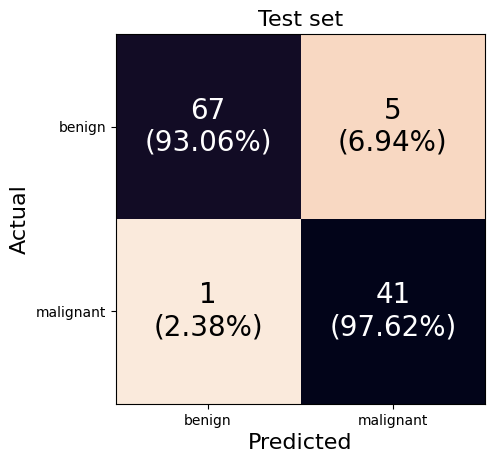

---------------------------------------
AUC validate: 98.30%
AUC test: 98.31%


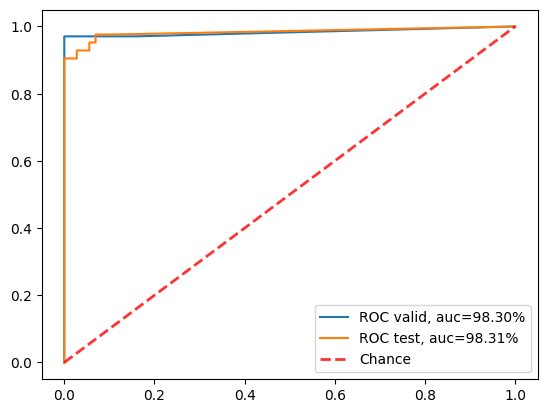

                   Variable      Coef
1                 area_mean  1.909921
3            concavity_mean  0.974228
7                   area_se  0.882497
14           symmetry_worst  0.715540
13          concavity_worst  0.653300
5    fractal_dimension_mean  0.642374
12         smoothness_worst  0.582648
9              concavity_se  0.509842
10              symmetry_se  0.502113
8             smoothness_se  0.452799
0              texture_mean  0.451153
15  fractal_dimension_worst  0.348648
6                texture_se  0.324249
11     fractal_dimension_se  0.292496
4             symmetry_mean  0.092789
2           smoothness_mean  0.039240
################# false predict ##################
        id diagnosis  texture_mean  area_mean  smoothness_mean  \
62  914580         B         17.31      480.1          0.08928   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
62         0.03609         0.1526                 0.06046       0.781   

    area_se  smoothness

In [202]:
param = 5
param5_split2_cm_val, param5_split2_cm_test, param5_split2_AUC_val, param5_split2_AUC_test = evaluate(param,split)

## split3

In [203]:
split_num = 3
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3/split3/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3/split3/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [204]:
# train_param5(split)

../SGD/models/param5/sgd_model_split3.pkl
############## validate set ################
Best Threshold=0.945042
FPR: 0.0175
TPR: 0.9706
Confusion Matrix
----------------
[[56  1]
 [ 1 33]] 

----------------
split3
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%


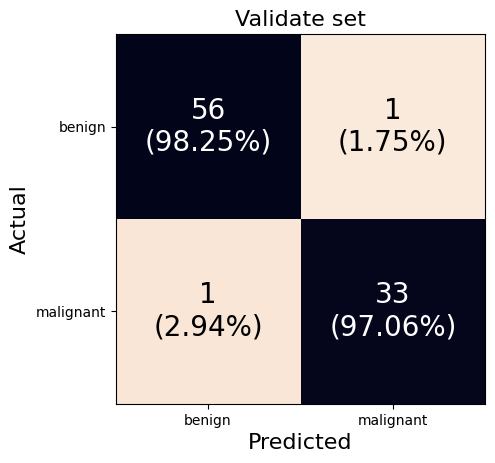

################# test set ##################
Best Threshold=0.545175
FPR: 0.0278
TPR: 0.9762
Confusion Matrix
----------------
[[70  2]
 [ 1 41]] 

----------------
split3
Sensitivity: 97.62%
Specificity: 97.22%
Accuracy: 97.37%
Precision: 95.35%
Sensitivity: 97.62%
Precision: 95.35%
F1: 96.47%


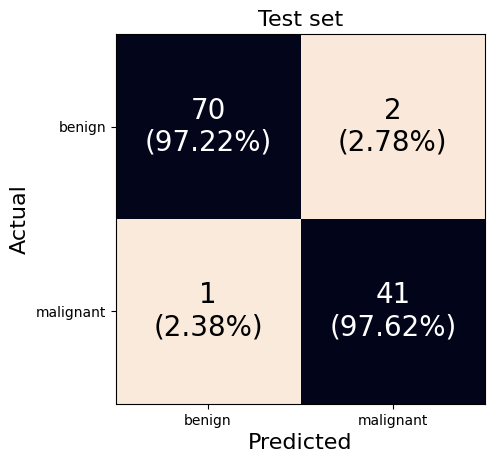

---------------------------------------
AUC validate: 98.94%
AUC test: 97.73%


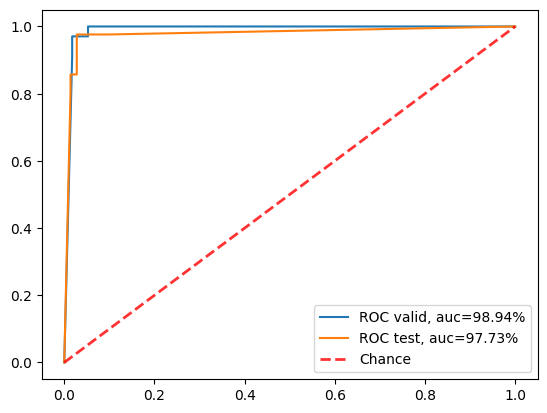

                   Variable      Coef
1                 area_mean  1.906039
7                   area_se  1.043102
13          concavity_worst  0.926898
3            concavity_mean  0.858891
11     fractal_dimension_se  0.809256
14           symmetry_worst  0.641070
10              symmetry_se  0.510837
0              texture_mean  0.508157
6                texture_se  0.389807
9              concavity_se  0.350310
12         smoothness_worst  0.349925
8             smoothness_se  0.349556
5    fractal_dimension_mean  0.296623
15  fractal_dimension_worst  0.194620
4             symmetry_mean  0.129126
2           smoothness_mean  0.074676
################# false predict ##################
         id diagnosis  texture_mean  area_mean  smoothness_mean  \
14   863270         B         18.54      466.7          0.08477   
57  8810528         B         18.94      428.0          0.08871   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
14         0.02643         0

In [205]:
param = 5
param5_split3_cm_val, param5_split3_cm_test, param5_split3_AUC_val, param5_split3_AUC_test = evaluate(param,split)

## split4

In [206]:
split_num = 4
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3/split4/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3/split4/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [207]:
# train_param5(split)

../SGD/models/param5/sgd_model_split4.pkl
############## validate set ################
Best Threshold=0.594679
FPR: 0.0175
TPR: 1.0000
Confusion Matrix
----------------
[[56  1]
 [ 0 34]] 

----------------
split4
Sensitivity: 100.00%
Specificity: 98.25%
Accuracy: 98.90%
Precision: 97.14%
Sensitivity: 100.00%
Precision: 97.14%
F1: 98.55%


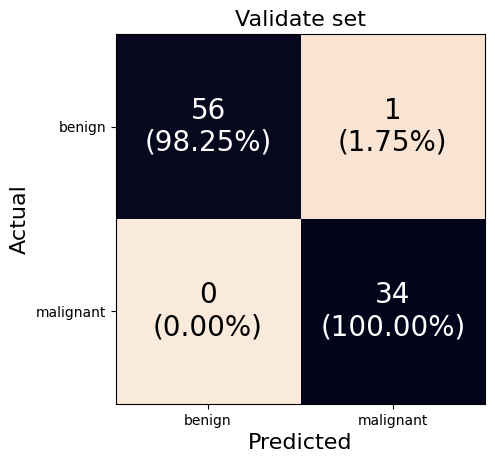

################# test set ##################
Best Threshold=0.576150
FPR: 0.0278
TPR: 0.9762
Confusion Matrix
----------------
[[70  2]
 [ 1 41]] 

----------------
split4
Sensitivity: 97.62%
Specificity: 97.22%
Accuracy: 97.37%
Precision: 95.35%
Sensitivity: 97.62%
Precision: 95.35%
F1: 96.47%


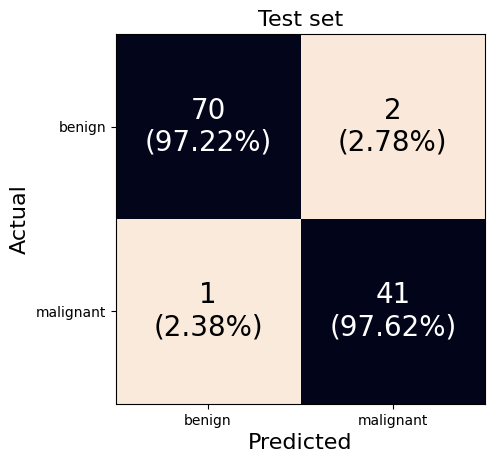

---------------------------------------
AUC validate: 99.95%
AUC test: 98.35%


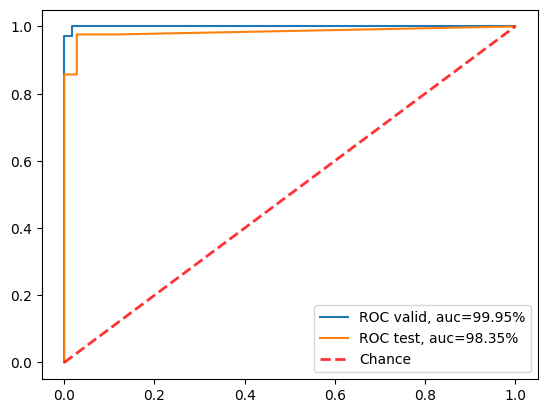

                   Variable      Coef
1                 area_mean  1.612646
7                   area_se  0.940910
3            concavity_mean  0.925875
14           symmetry_worst  0.818270
11     fractal_dimension_se  0.726111
13          concavity_worst  0.673915
10              symmetry_se  0.562507
0              texture_mean  0.538050
9              concavity_se  0.441007
15  fractal_dimension_worst  0.295482
12         smoothness_worst  0.289066
8             smoothness_se  0.286519
6                texture_se  0.271656
5    fractal_dimension_mean  0.233491
2           smoothness_mean  0.051010
4             symmetry_mean  0.022654
################# false predict ##################
        id diagnosis  texture_mean  area_mean  smoothness_mean  \
3  8910721         B         16.82      632.6          0.06429   

   concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  area_se  \
3         0.00725         0.1508                 0.05376      0.7198    10.77   

   smoo

In [208]:
param = 5
param5_split4_cm_val, param5_split4_cm_test, param5_split4_AUC_val, param5_split4_AUC_test = evaluate(param,split)

## split5

In [209]:
split_num = 5
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3/split5/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3/split5/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [210]:
# train_param5(split)

../SGD/models/param5/sgd_model_split5.pkl
############## validate set ################
Best Threshold=0.673524
FPR: 0.0175
TPR: 0.9706
Confusion Matrix
----------------
[[56  1]
 [ 1 33]] 

----------------
split5
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%


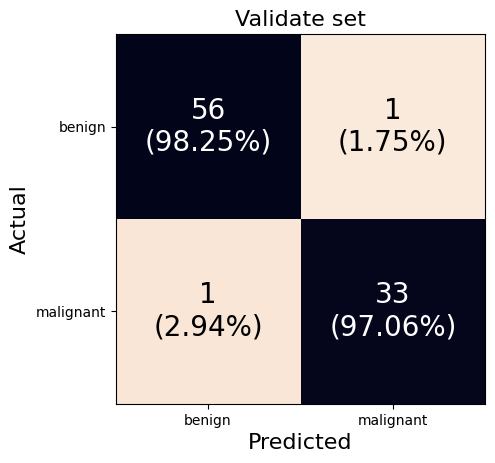

################# test set ##################
Best Threshold=0.249687
FPR: 0.0278
TPR: 0.9762
Confusion Matrix
----------------
[[70  2]
 [ 1 41]] 

----------------
split5
Sensitivity: 97.62%
Specificity: 97.22%
Accuracy: 97.37%
Precision: 95.35%
Sensitivity: 97.62%
Precision: 95.35%
F1: 96.47%


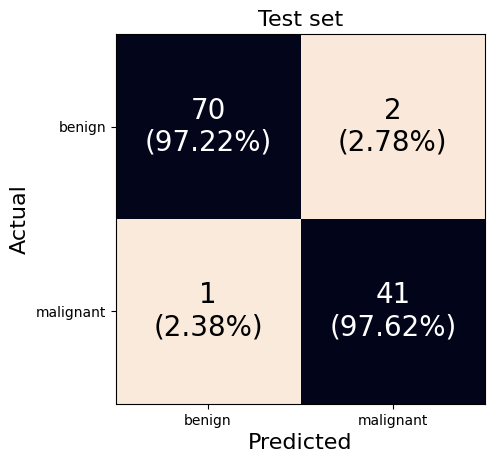

---------------------------------------
AUC validate: 99.69%
AUC test: 98.46%


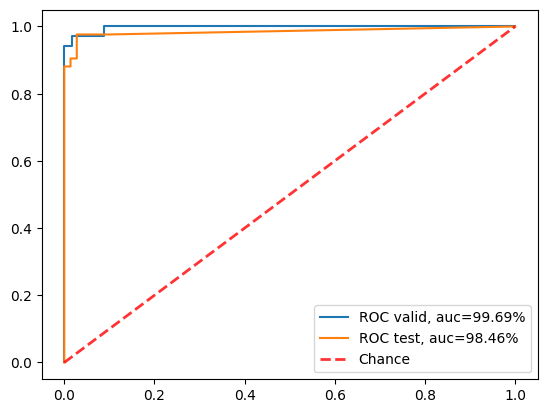

                   Variable      Coef
1                 area_mean  1.523755
7                   area_se  1.051275
3            concavity_mean  0.977020
13          concavity_worst  0.892861
0              texture_mean  0.611455
12         smoothness_worst  0.534429
11     fractal_dimension_se  0.507142
10              symmetry_se  0.479059
14           symmetry_worst  0.402257
9              concavity_se  0.383298
5    fractal_dimension_mean  0.220779
2           smoothness_mean  0.180548
6                texture_se  0.134828
8             smoothness_se  0.130854
15  fractal_dimension_worst  0.120160
4             symmetry_mean  0.106549
################# false predict ##################
         id diagnosis  texture_mean  area_mean  smoothness_mean  \
35  8911230         B         14.16      396.6          0.09379   
79   867739         M         21.91     1075.0          0.09430   

    concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
35        0.001487         0

In [211]:
param = 5
param5_split5_cm_val, param5_split5_cm_test, param5_split5_AUC_val, param5_split5_AUC_test = evaluate(param,split)

# Overall

## param1

param1
split1
Sensitivity: 100.00%
Specificity: 98.25%
Accuracy: 98.90%
Precision: 97.14%
Sensitivity: 100.00%
Precision: 97.14%
F1: 98.55%

split2
Sensitivity: 97.06%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 97.06%
Precision: 100.00%
F1: 98.51%

split3
Sensitivity: 97.06%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 97.06%
Precision: 100.00%
F1: 98.51%

split4
Sensitivity: 100.00%
Specificity: 98.25%
Accuracy: 98.90%
Precision: 97.14%
Sensitivity: 100.00%
Precision: 97.14%
F1: 98.55%

split5
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%

overall
sensitivity: 98.24 ± 1.61%
specificity: 98.95 ± 0.96%
accuracy: 98.68 ± 0.49%
precision: 98.27 ± 1.58%
f1_score: 98.24 ± 0.66%


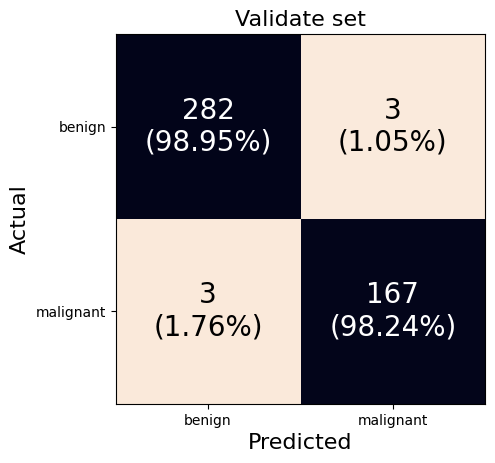

AUC1: 9949.95 ± 70.50%


In [116]:
print("param1")
plot(param1_split1_cm_val , param1_split2_cm_val , param1_split3_cm_val , param1_split4_cm_val , param1_split5_cm_val)
Mean_SD("AUC1",param1_split1_AUC_val*100, param1_split2_AUC_val*100, param1_split3_AUC_val*100, param1_split4_AUC_val*100, param1_split5_AUC_val*100)

## param2

param2
split1
Sensitivity: 100.00%
Specificity: 98.25%
Accuracy: 98.90%
Precision: 97.14%
Sensitivity: 100.00%
Precision: 97.14%
F1: 98.55%

split2
Sensitivity: 94.12%
Specificity: 98.25%
Accuracy: 96.70%
Precision: 96.97%
Sensitivity: 94.12%
Precision: 96.97%
F1: 95.52%

split3
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%

split4
Sensitivity: 100.00%
Specificity: 96.49%
Accuracy: 97.80%
Precision: 94.44%
Sensitivity: 100.00%
Precision: 94.44%
F1: 97.14%

split5
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%

overall
sensitivity: 97.65 ± 2.46%
specificity: 97.89 ± 0.78%
accuracy: 97.80 ± 0.78%
precision: 96.53 ± 1.17%
f1_score: 97.07 ± 1.07%


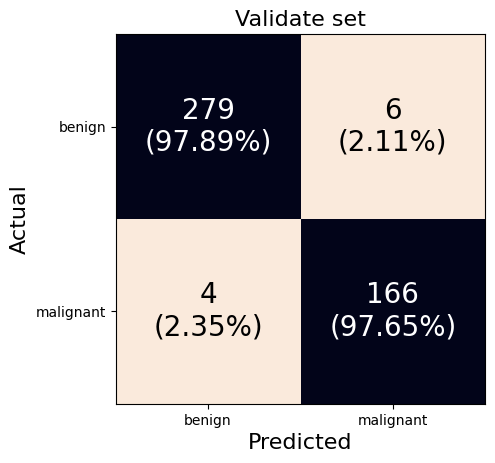

AUC1: 9777.09 ± 107.32%


In [176]:
print("param2")
plot(param2_split1_cm_val , param2_split2_cm_val , param2_split3_cm_val , param2_split4_cm_val , param2_split5_cm_val)
Mean_SD("AUC1",param2_split1_AUC_val*100, param2_split2_AUC_val*100, param2_split3_AUC_val*100, param2_split4_AUC_val*100, param2_split5_AUC_val*100)

## param3

param3
split1
Sensitivity: 97.06%
Specificity: 96.49%
Accuracy: 96.70%
Precision: 94.29%
Sensitivity: 97.06%
Precision: 94.29%
F1: 95.65%

split2
Sensitivity: 97.06%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 97.06%
Precision: 100.00%
F1: 98.51%

split3
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%

split4
Sensitivity: 100.00%
Specificity: 96.49%
Accuracy: 97.80%
Precision: 94.44%
Sensitivity: 100.00%
Precision: 94.44%
F1: 97.14%

split5
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%

overall
sensitivity: 97.65 ± 1.32%
specificity: 97.89 ± 1.47%
accuracy: 97.80 ± 0.78%
precision: 96.57 ± 2.34%
f1_score: 97.08 ± 1.01%


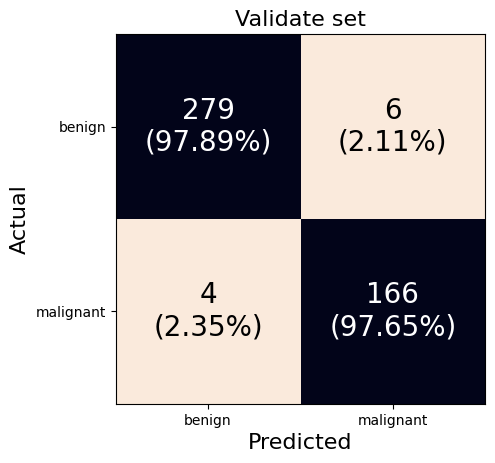

AUC1: 9777.09 ± 67.47%


In [177]:
print("param3")
plot(param3_split1_cm_val , param3_split2_cm_val , param3_split3_cm_val , param3_split4_cm_val , param5_split5_cm_val)
Mean_SD("AUC1",param3_split1_AUC_val*100, param3_split2_AUC_val*100, param3_split3_AUC_val*100, param3_split4_AUC_val*100, param3_split5_AUC_val*100)

## param4

param4
split1
Sensitivity: 97.06%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 97.06%
Precision: 100.00%
F1: 98.51%

split2
Sensitivity: 97.06%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 97.06%
Precision: 100.00%
F1: 98.51%

split3
Sensitivity: 97.06%
Specificity: 94.74%
Accuracy: 95.60%
Precision: 91.67%
Sensitivity: 97.06%
Precision: 91.67%
F1: 94.29%

split4
Sensitivity: 100.00%
Specificity: 98.25%
Accuracy: 98.90%
Precision: 97.14%
Sensitivity: 100.00%
Precision: 97.14%
F1: 98.55%

split5
Sensitivity: 94.12%
Specificity: 100.00%
Accuracy: 97.80%
Precision: 100.00%
Sensitivity: 94.12%
Precision: 100.00%
F1: 96.97%

overall
sensitivity: 97.06 ± 2.08%
specificity: 98.60 ± 2.29%
accuracy: 98.02 ± 1.43%
precision: 97.76 ± 3.62%
f1_score: 97.36 ± 1.85%


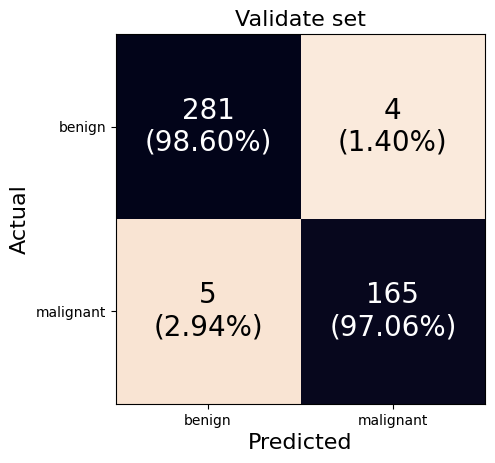

AUC1: 9948.40 ± 36.12%


In [178]:
print("param4")
plot(param4_split1_cm_val , param4_split2_cm_val , param4_split3_cm_val , param4_split4_cm_val , param4_split5_cm_val)
Mean_SD("AUC1",param4_split1_AUC_val*100, param4_split2_AUC_val*100, param4_split3_AUC_val*100, param4_split4_AUC_val*100, param4_split5_AUC_val*100)

## param5

param5
split1
Sensitivity: 100.00%
Specificity: 98.25%
Accuracy: 98.90%
Precision: 97.14%
Sensitivity: 100.00%
Precision: 97.14%
F1: 98.55%

split2
Sensitivity: 97.06%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 97.06%
Precision: 100.00%
F1: 98.51%

split3
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%

split4
Sensitivity: 100.00%
Specificity: 98.25%
Accuracy: 98.90%
Precision: 97.14%
Sensitivity: 100.00%
Precision: 97.14%
F1: 98.55%

split5
Sensitivity: 97.06%
Specificity: 98.25%
Accuracy: 97.80%
Precision: 97.06%
Sensitivity: 97.06%
Precision: 97.06%
F1: 97.06%

overall
sensitivity: 98.24 ± 1.61%
specificity: 98.60 ± 0.78%
accuracy: 98.46 ± 0.60%
precision: 97.68 ± 1.30%
f1_score: 97.95 ± 0.81%


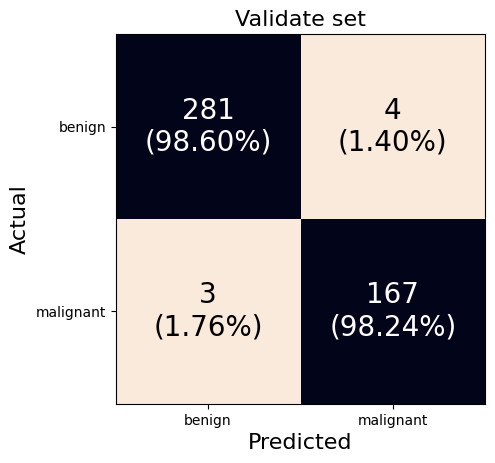

AUC1: 9934.47 ± 70.60%


In [179]:
print("param5")
plot(param5_split1_cm_val , param5_split2_cm_val , param5_split3_cm_val , param5_split4_cm_val , param5_split5_cm_val)
Mean_SD("AUC1",param5_split1_AUC_val*100, param5_split2_AUC_val*100, param5_split3_AUC_val*100, param5_split4_AUC_val*100, param5_split5_AUC_val*100)

# Test best param

In [192]:
train_path = "../kitt/DATA_progress3/train.csv"
test_path = "../kitt/DATA_progress3/test.csv"

In [193]:
# Load the train set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the test se
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[2:]]
print(x_test.shape)
y_test = test_data[test_data.columns[1]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# StandardScaler
sc = StandardScaler()
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

(455, 18)
(455, 16)
['B' 'M']
(114, 18)
(114, 16)
['B' 'M']


In [194]:
model = SGDClassifier(loss='modified_huber', penalty='l2', learning_rate='constant', eta0=0.01, max_iter=5000, alpha=0.01)
model.fit(x_train, y_train)# Save the trained model to disk
joblib.dump(model, "../SGD/models/sgd_model_all.pkl")

['../SGD/models/sgd_model_all.pkl']

../SGD/models/sgd_model_all.pkl
################# test set ##################
Best Threshold=0.415628
FPR: 0.0278
TPR: 0.9762
Confusion Matrix
----------------
[[70  2]
 [ 1 41]] 

----------------
split5
Sensitivity: 97.62%
Specificity: 97.22%
Accuracy: 97.37%
Precision: 95.35%
Sensitivity: 97.62%
Precision: 95.35%
F1: 96.47%


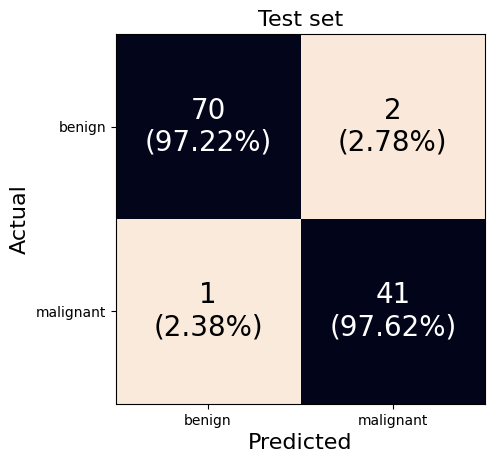

---------------------------------------
AUC test: 98.56%


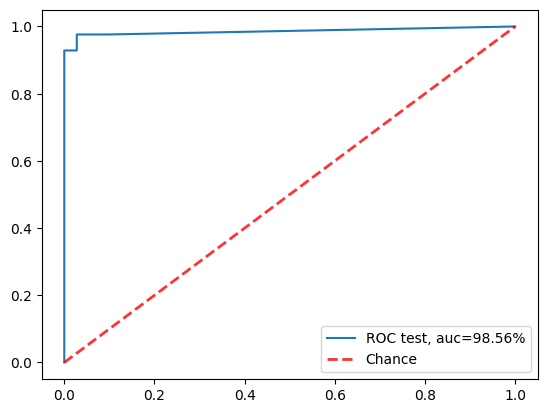

In [195]:
model_path = "../SGD/models/sgd_model_all.pkl"
print(model_path)
loaded_model = joblib.load(model_path)

# ################# test set ##################
label = ['benign','malignant']
print("################# test set ##################")
y_pred_test_raw = loaded_model.predict_proba(x_test)
y_pred_test = thresholding(y_test, y_pred_test_raw)

# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
print(split)
cal_score_all(cm_test)

# plot confusion matrix
plot_cm(cm_test,which="Test set")

################## plot ROC curve ########################
# fpr1, tpr1, thr1 = metrics.roc_curve(y_val,  y_pred_val_raw[:,1])
# auc1 = metrics.roc_auc_score(y_val,  y_pred_val_raw[:,1])*100
fpr2, tpr2, thr2 = metrics.roc_curve(y_test,  y_pred_test_raw[:,1])
auc2 = metrics.roc_auc_score(y_test,  y_pred_test_raw[:,1])*100
gmeans2 = np.sqrt(tpr2 * (1-fpr2))
ix2 = np.argmax(gmeans2)
print("---------------------------------------")
# print("AUC validate: %.2f%%" % auc1)
print("AUC test: %.2f%%" % auc2)
# plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.2f%%" % auc1))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.2f%%" % auc2))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

plt.legend(loc=4)
plt.show()